In [19]:
import pandas as pd
import xarray as xr
import requests
import matplotlib.pyplot as plt
import shapely
import geopandas as gpd
import metpy
import numpy as np

## Section 1: Storm Reports ##

In [20]:
#Gets wind report on given date as a pandas dataframe
def get_wind_report(datetime):
    date = datetime.strftime("%y%m%d")
    df = request_wind_report_df(date)    
    df = add_datetime(df, datetime)
    return df

#Helper functions 
#Requests the wind report from the NOAA website and cleans up the data
def request_wind_report_df(date):
    #Actual request
    link = generate_link(date)
    data = requests.get(link)
    #Turns csv string into dataFrame
    csv_string = data.text
    data = [row.split(',') for row in csv_string.split('\n')]
    data.pop(-1)
    columns = data.pop(0)
    data.pop(0)
    #Returns dataframe 
    df = pd.DataFrame(data, columns=columns)
    df["Lat"] = df["Lat"].astype("float")
    df["Lon"] = df["Lon"].astype("float")
    return df

#Adds date time column to the dataframe
def add_datetime(df, datetime):
    time = df["Time"]
    #TODO: Rename foo function
    df["datetime"] = [foo(datetime, t) for t in time]
    df['datetime'] = pd.to_datetime(df["datetime"])
    #Removes Time column
    df.drop(columns=["Time"], inplace=True)
    return df 

#Corrects the date for a given report
#TODO: Rename this function
def foo(datetime, time):
    day = datetime.day if int(time[0] + time[1]) >= 12 else (datetime + pd.Timedelta(days = 1)).day
    dt = pd.Timestamp(year=datetime.year, month=datetime.month,
                                   day=day, hour=int(time[0] + time[1]),
                                  minute = int(time[2] + time[3]))
    return dt



#Generates link to csv download of wind report on given date. Date format "yymmdd"
def generate_link(date):
    return f'https://www.spc.noaa.gov/climo/reports/{date}_rpts_wind.csv'



In [21]:
#Returns pandas dataframe with wind reports for given date range
def get_weather_reports(start_date, end_date):    
    i = 0
    for date in generate_days(start_date, end_date):
        df = get_wind_report(date)
        if i == 0:
            big_df = df
            i += 1
        else :
            big_df = pd.concat([big_df, df])
    big_df.reset_index(inplace=True)
    return big_df

#Helper function
#Generates dates in format "yymmdd"
def generate_days(start_date, end_date):
    
    days = pd.period_range(start=start_date, end=end_date)
    # days = [day.strftime("%y%m%d") for day in days]
    return days


In [22]:
#Applies filters to the storm report dataset
def filter_reports(df, center_event, distance, hours):
    spatially_filtered = spatial_filter(df, center_event["Lat"], center_event["Lon"], distance)
    temporally_filtered = temporal_filter(spatially_filtered, hours,center_event["datetime"], )
    return temporally_filtered

#Filters the storm reports so that only the ones that are +- hours from the given date time
def temporal_filter(df, hours, date_time):
    filtered_df = df[df["datetime"] >= (date_time - pd.Timedelta(hours=hours))]
    time_filtered_events = filtered_df[filtered_df["datetime"] <= (date_time + pd.Timedelta(hours=hours))]
    return time_filtered_events

#Filters storm reports so that only the ones that are +- distance from given lat/lon
#TODO: Enhance so that we can give the distance in kilometers
def spatial_filter(df, lat, lon, distance):
    lat_filtered_df = latitude_filter(df, lat, distance)
    filtered_df = longitude_filter(lat_filtered_df, lon, distance)
    return filtered_df

#Helper functions for the spatial filter
def latitude_filter(df, lat, distance):
    val = lat + distance
    lat_filtered = df[df["Lat"] <= val]
    lat_filtered = lat_filtered[lat_filtered["Lat"] >= lat - distance]
    return lat_filtered

def longitude_filter(df, lon, distance):
    lon_filtered = df[df["Lon"] <= lon + distance]
    lon_filtered = lon_filtered[lon_filtered["Lon"] >= lon - distance]
    return lon_filtered
    

In [23]:
#Wind reports for June 7 2023
get_wind_report(pd.Timestamp(year=2023, month=6, day=7))

Speed           Location       County State    Lat     Lon  \
0    UNK         3 NE Reese       Warren    GA  33.37  -82.55   
1    UNK        2 NNE Reese       Warren    GA  33.37  -82.56   
2    UNK  2 WSW Franklinton         Bibb    GA  32.79  -83.57   
3    UNK         3 NNE Cope   Orangeburg    SC  33.42  -80.98   
4    UNK  4 SW Logan Center  Grand Forks    ND  47.77  -97.87   
..   ...                ...          ...   ...    ...     ...   
71    59       Laughlin AFB    Val Verde    TX  29.36 -100.78   
72   UNK       2 NNE Bergen      Jackson    MN  43.82  -94.99   
73   UNK         5 S Bergen      Jackson    MN  43.72  -95.00   
74   UNK        3 NE Harris      Osceola    IA  43.48  -95.39   
75   UNK         San Benito      Cameron    TX  26.14  -97.64   

                                             Comments            datetime  
0   Trees and powerlines down at Ricketson Road ne... 2023-06-07 19:37:00  
1   Trees and powerlines down on Little Briar Cree... 2023-06-07 19:37:00  
2   Trained spotter reports that a microburst occu... 2023-06-07 19:38:00  
3   Trees and power lines down at Shillings Bridge... 2023-06-07 20:12:00  
4   Corrects previous tstm wnd dmg report from 4 S... 2023-06-07 20:13:00  
..                                                ...                 ...  
71                                              (EWX) 2023-06-08 06:23:00  
72  A large cottonwood tree was uprooted. Grain au... 2023-06-08 07:03:00  
73  Ten power poles snapped off for a half mile we... 2023-06-08 07:14:00  
74  Grain bin and large trees damaged by thunderst... 2023-06-08 08:57:00  
75  Public relayed via social media that RV jack w... 2023-06-08 11:50:00  

[76 rows x 8 columns]

Generates wind reports for dates in a given range 

In [24]:
#Generates wind reports until the most recent day
start_date = pd.Timestamp(year=2023, month=5, day=8)
end_date = pd.Timestamp(year=2023, month=6, day=14)
reports = get_weather_reports(start_date, end_date)
reports 

Deals with the filtering of storm report data. Can filter spatially and temporally. 

## Section 2: RRFS Model Data ##

In [25]:
from rrfs import rrfs
r = rrfs.Rrfs()

#Inputs storm_report row and the forecast hour
#Outputs xarray dataset with model forecast
#TODO: Needs to be updated
def fetch_rrfs_forecast(storm_report, forecast_hour, bounding_box=False,variable_list=False):
    storm_report["datetime"] - pd.Timedelta(hours=forecast_hour)
    return r.fetch_model_outputs(initialization_date, forecast_hour, bounding_box, variable_list)
   

In [26]:
#Given a xarray dataset, interesting_event and distance, filters the dataset to only contain cells += distance from the center event
def bounding_indexes(ds, i_event, distance):
    lat_grid, lon_grid = ds['gridlat_0'].values, ds['gridlon_0'].values
    lat, lon = i_event["Lat"], i_event["Lon"]
    lat_size = len(lat_grid) #1059
    lon_size = len(lat_grid[0]) #1799
        
    lat_indexes, lon_indexes = [], []
    
    for lat_index in range(lat_size):
        for lon_index in range(lon_size):
            if abs(lat_grid[lat_index][lon_index] - lat) < distance and abs(lon_grid[lat_index][lon_index] - lon) < distance:
                lat_indexes.append(lat_index)
                lon_indexes.append(lon_index)

    min_lat_index, max_lat_index = min(lat_indexes), max(lat_indexes)
    min_lon_index, max_lon_index = min(lon_indexes), max(lon_indexes)
    return min_lat_index, max_lat_index, min_lon_index, max_lon_index

#Helper function i think
def get_coords(ds, lat_ind, lon_ind):
    return ds.coords["gridlat_0"][lat_ind, lon_ind].values, ds.coords["gridlon_0"][lat_ind, lon_ind].values

#Unused
def get_latlons(min_lat, max_lat, min_lon, max_lon):
    lats = []
    lons = []
    for lat_index in range(min_lat, max_lat):
        for lon_index in range(min_lon, max_lon):
            lat, lon = get_coords(ds, lat_index, lon_index)
            lats.append(lat)
            lons.append(lon)
    return lats, lons

In [27]:
#TODO: Add something that returns xarray dataset with only the given variable or variables

## Section 3: Plotting Data ##

In [28]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#Plots weather reports
def plot_storm_reports(events, center_event=False, distance=1, surrogate=False):

    figure = plt.figure()
    
    ax = figure.add_subplot(1,1,1,projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.STATES)
    ax.set_extent(
        [-125, -75, 25, 50],
        crs=ccrs.PlateCarree()
    )

    if surrogate:
        color = 'blue'
    else :
        color = 'red'
    
    plt.scatter(
        x = events["Lon"],
        y = events["Lat"],
        color=color,
        s=2,
        alpha=1,
        transform=ccrs.PlateCarree()
    )
    if center_event:
        plt.scatter(
            x = center_event["Lon"],
            y = center_event["Lat"],
            color="green",
            s=4,
            alpha=1,
            transform=ccrs.PlateCarree()
        )

    plt.show()

In [29]:
# Wind Speed Calculation

import matplotlib.pyplot as plt
import metpy.calc as mpcalc

#Plots winds speed and 
def plot_wind_speed(ds, interesting_events, center_event, offset=3):

    # Calculate the total deformation of the flow
    wind_speed = mpcalc.wind_speed(ds.UGRD_P0_L103_GLC0, ds.VGRD_P0_L103_GLC0)
    # start figure and set axis
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # plot wind speed
    cf = ax.contourf(ds.coords['gridlon_0'], 
                     ds.coords['gridlat_0'], 
                     wind_speed, cmap=plt.cm.BuPu)
    plt.colorbar(cf, pad=0, aspect=50)
    ax.barbs(ds.coords['gridlon_0'][0::offset, 0::offset],
             ds.coords['gridlat_0'][0::offset, 0::offset],
             ds.UGRD_P0_L103_GLC0[0::offset, 0::offset], 
             ds.VGRD_P0_L103_GLC0[0::offset, 0::offset], 
             color='black', length=5, alpha=0.5)
   
    ax.set_title('Wind Speed Calculation')
    
    plt.scatter(
            x = interesting_events["Lon"],
            y = interesting_events["Lat"],
            color="red",
            s=2,
            alpha=1
        )
    
    plt.scatter(
        x=center_event["Lon"],
        y=center_event["Lat"],
        color="Orange",
        s=5
    )
    plt.show()

#Plots the max wind speed variable
def plot_max_wind_speed(ds, interesting_events, center_event, offset=3):

    # Calculate the total deformation of the flow
    wind_speed = mpcalc.wind_speed(ds.MAXUW_P8_L103_GLC0_max1h, ds.MAXVW_P8_L103_GLC0_max1h)
    # start figure and set axis
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # plot wind speed
    cf = ax.contourf(ds.coords['gridlon_0'], 
                     ds.coords['gridlat_0'], 
                     wind_speed, cmap=plt.cm.YlGn)
    plt.colorbar(cf, pad=0, aspect=50)
    ax.barbs(ds.coords['gridlon_0'][0::offset, 0::offset],
             ds.coords['gridlat_0'][0::offset, 0::offset],
             ds.UGRD_P0_L103_GLC0[0::offset, 0::offset], 
             ds.VGRD_P0_L103_GLC0[0::offset, 0::offset], 
             color='black', length=5, alpha=0.5)
   
    ax.set_title('Max Wind Speed')
    
    plt.scatter(
            x = interesting_events["Lon"],
            y = interesting_events["Lat"],
            color="red",
            s=2,
            alpha=1
        )
    
    plt.scatter(
        x=center_event["Lon"],
        y=center_event["Lat"],
        color="Orange",
        s=5
    )
    plt.show()


def contour_plot(ds, interesting_events, center_event, variable):
    #Plots the max wind speed variable
    # Calculate the total deformation of the flow
    # wind_speed = mpcalc.wind_speed(ds.MAXUW_P8_L103_GLC0_max1h, ds.MAXVW_P8_L103_GLC0_max1h)
    # start figure and set axis
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # plot wind speed
    cf = ax.contourf(ds.coords['gridlon_0'], 
                     ds.coords['gridlat_0'], 
                     ds[variable], cmap=plt.cm.Purples)
    plt.colorbar(cf, pad=0, aspect=50)
    ax.set_title('Name')
    
    plt.scatter(
            x = interesting_events["Lon"],
            y = interesting_events["Lat"],
            color="red",
            s=2,
            alpha=1
        )
    
    plt.scatter(
        x=center_event["Lon"],
        y=center_event["Lat"],
        color="Orange",
        s=5
    )
    plt.show()



In [30]:
#Top level function that puts everything together
def plot_interesting_events(center_event, storm_reports, forecast_hour, distance, time):
    offset = 10
    #Fetches forecast
    ds = fetch_rrfs_forecast(center_event, forecast_hour)
    interesting_events = filter_reports(storm_reports, center_event, distance, time)
    #Filters the dataset
    mla, Mla, mlo, Mlo = bounding_indexes(ds, center_event, distance + 1)
    new_ds = ds.isel(ygrid_0=range(mla,Mla), xgrid_0=range(mlo,Mlo))
    #TODO: Call the function that returns the given variable
    #TODO: Be smarter in how the plotting is done
    plot_wind_speed(new_ds, interesting_events, center_event, offset)
    plot_max_wind_speed(new_ds, interesting_events, center_event, offset)
    contour_plot(new_ds, interesting_events, center_event, 'GUST_P0_L1_GLC0')
    contour_plot(new_ds, interesting_events, center_event, 'MAXDVV_P8_2L100_GLC0_max1h')


In [31]:
def interesting_events(wind_reports):
    i = 0
    distance = 1
    hours = 1.5
    cool_events = []
    for index, row in wind_reports.iterrows():
        i += 1
        # print(i)
        # print(row)
        a = filter_reports(wind_reports, row, distance, hours)
        print(i, len(a))
        if len(a) > 20:
            cool_events.append(row)
    return cool_events

In [14]:
cool_events = interesting_events(reports)

1 10
2 10
3 1
4 10
5 10
6 10
7 10
8 10
9 10
10 10
11 10
12 1
13 1
14 1
15 2
16 2
17 1
18 1
19 3
20 3
21 3
22 5
23 1
24 13
25 14
26 20
27 17
28 19
29 18
30 19
31 1
32 19
33 22
34 1
35 20
36 22
37 21
38 22
39 20
40 22
41 20
42 20
43 2
44 19
45 22
46 2
47 14
48 13
49 14
50 14
51 14
52 14
53 14
54 14
55 14
56 14
57 14
58 14
59 14
60 14
61 14
62 14
63 14
64 4
65 4
66 4
67 4
68 3
69 3
70 3
71 2
72 2
73 8
74 8
75 8
76 9
77 11
78 11
79 8
80 12
81 4
82 4
83 14
84 13
85 13
86 7
87 14
88 8
89 15
90 15
91 1
92 15
93 15
94 15
95 17
96 6
97 6
98 6
99 11
100 16
101 16
102 12
103 19
104 13
105 5
106 19
107 22
108 13
109 14
110 1
111 23
112 14
113 20
114 14
115 1
116 20
117 14
118 14
119 17
120 14
121 6
122 14
123 15
124 15
125 19
126 17
127 12
128 14
129 6
130 15
131 18
132 14
133 16
134 8
135 16
136 9
137 15
138 2
139 8
140 13
141 15
142 10
143 14
144 14
145 8
146 12
147 14
148 11
149 1
150 14
151 16
152 14
153 2
154 8
155 9
156 2
157 14
158 8
159 2
160 1
161 4
162 8
163 3
164 13
165 12
166 1
167 14


## Interesting Report 1 ##

In [32]:
event_1 = reports.loc[189]
event_1

index                                                     119
Speed                                                     UNK
Location                                          SPRINGFIELD
County                                                 GREENE
State                                                      MO
Lat                                                      37.2
Lon                                                    -93.29
Comments    SEVERAL TREES AND LIMBS DOWN ACROSS POWERLINES...
datetime                                  2023-05-10 01:45:00
Name: 189, dtype: object

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

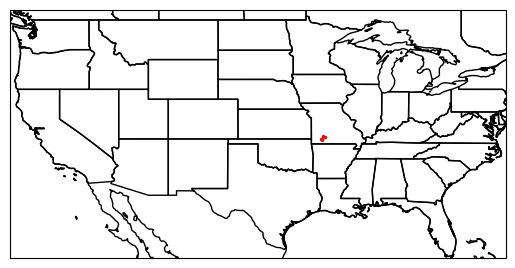

In [33]:
distance=1
hours=.5
filtered_data = filter_reports(reports, event_1, distance, hours)
plot_storm_reports(center_event=event_1, events=filtered_data, distance=1)

2023-06-14 22:59:00 3


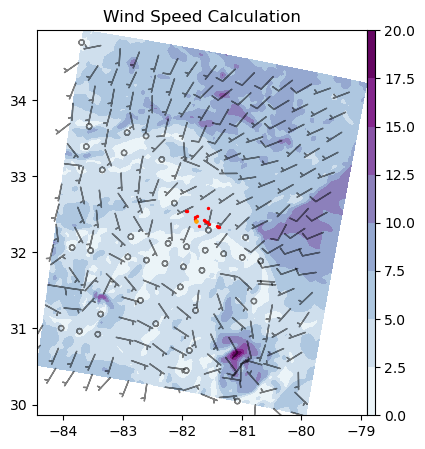

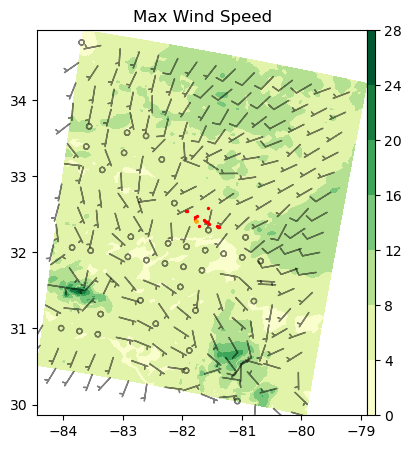

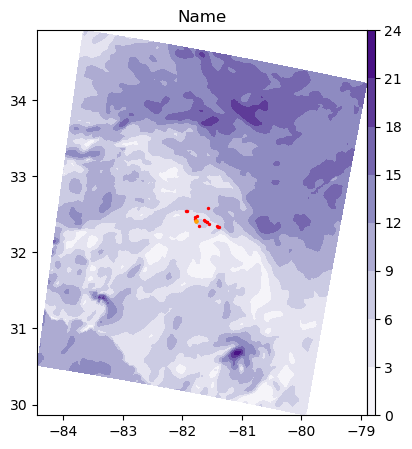

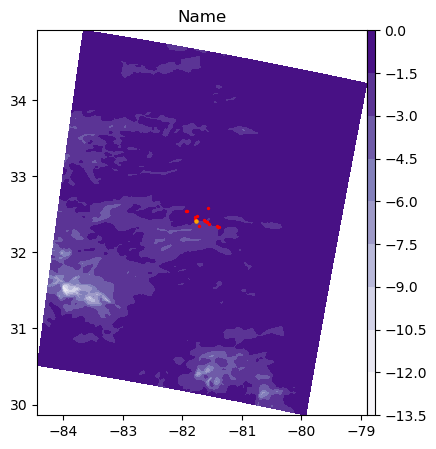

In [151]:
plot_interesting_events(event_1, filtered_data, 3, 1, .5)

2023-06-14 22:59:00 6


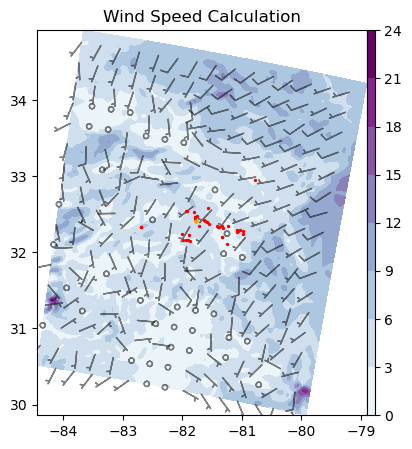

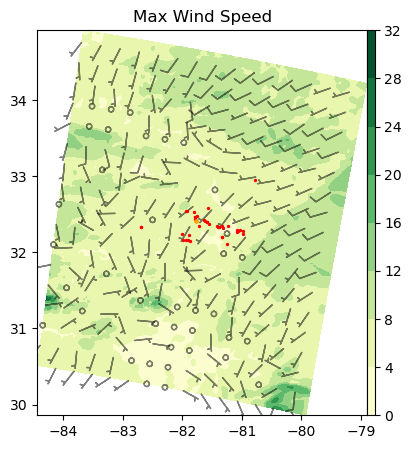

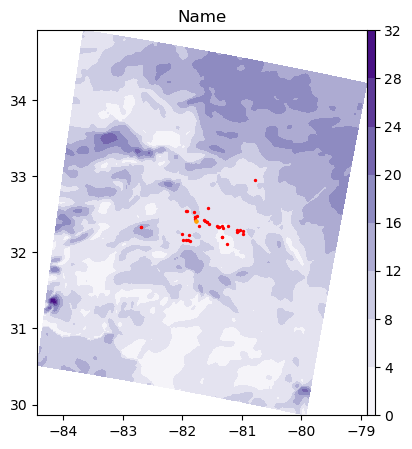

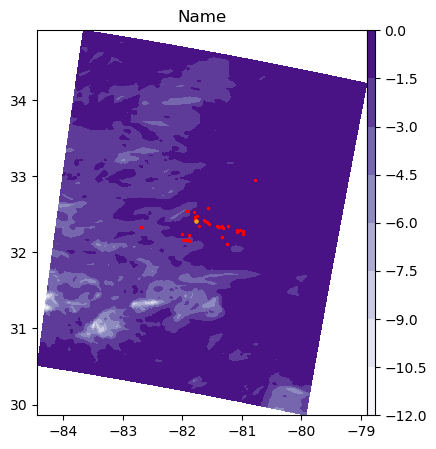

In [153]:
plot_interesting_events(event_1, filtered_data, 6, 1, 1)

2023-06-14 22:59:00 9


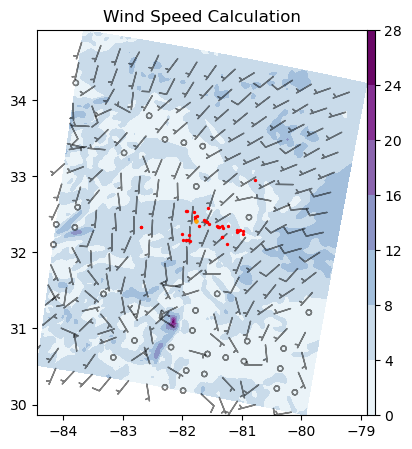

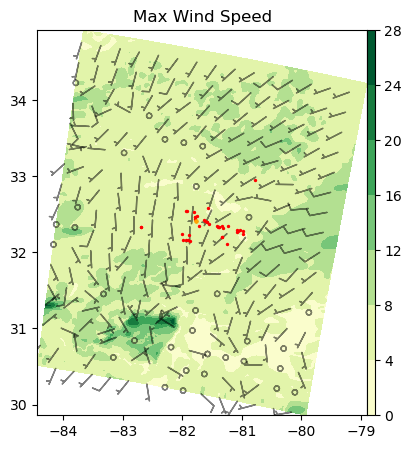

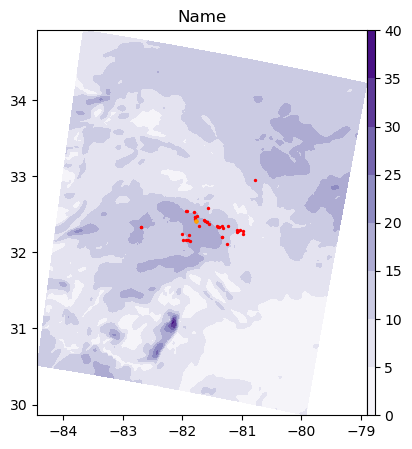

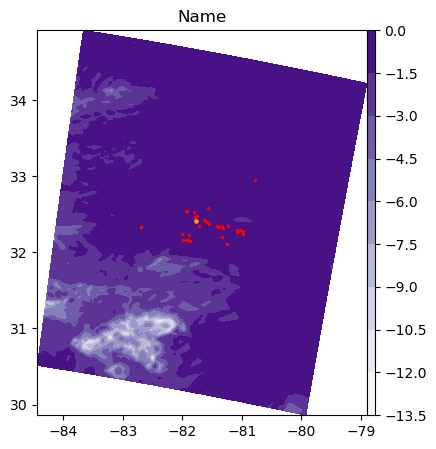

In [154]:
plot_interesting_events(event_1, filtered_data, 9, 1, 1)

## Interesting Report 2 ##

In [105]:
event_2 = wind_reports.loc[250]
event_2

Speed                                                     UNK
Location                                             Hartford
County                                                 Geneva
State                                                      AL
Lat                                                      31.1
Lon                                                     -85.7
Comments    Trees and powerlines reported down across Gene...
datetime                                  2023-06-14 23:54:00
Name: 250, dtype: object

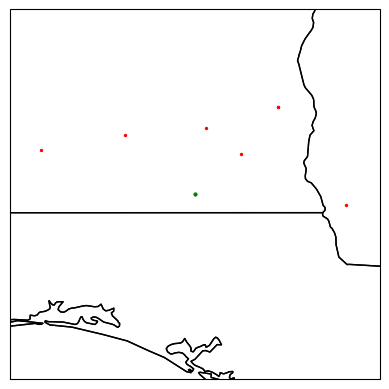

In [124]:
distance=1
hours=.5
filtered_data_2 = filter_reports(wind_reports, event_2, distance, hours)
plot_storm_reports(center_event=event_2, events=filtered_data_2, distance=1)

2023-06-14 23:54:00 3


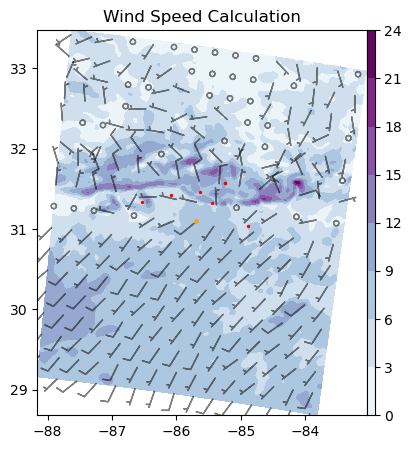

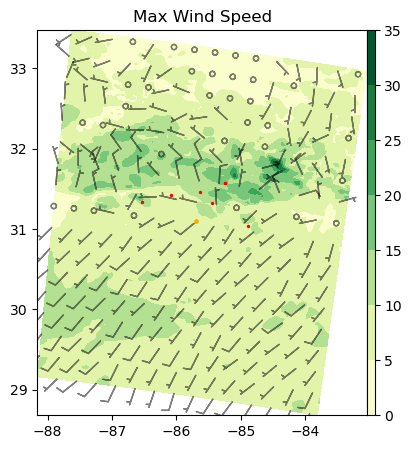

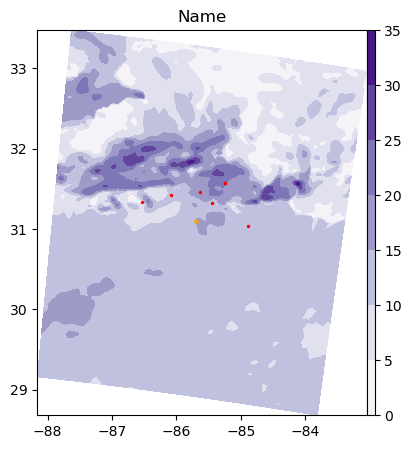

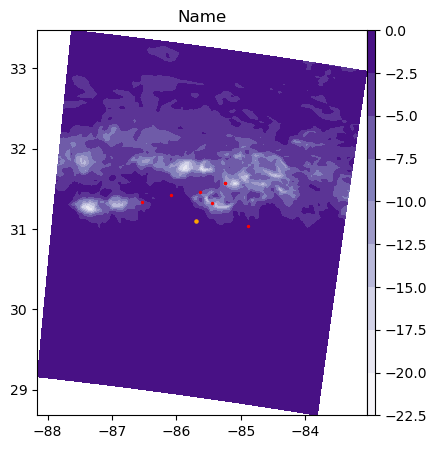

In [155]:
plot_interesting_events(event_2, filtered_data_2, forecast_hour=3, distance=1,time=.5)

2023-06-14 23:54:00 6


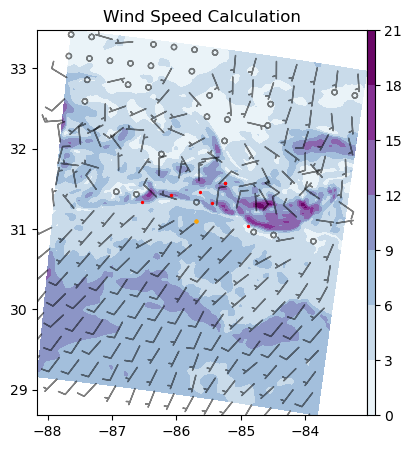

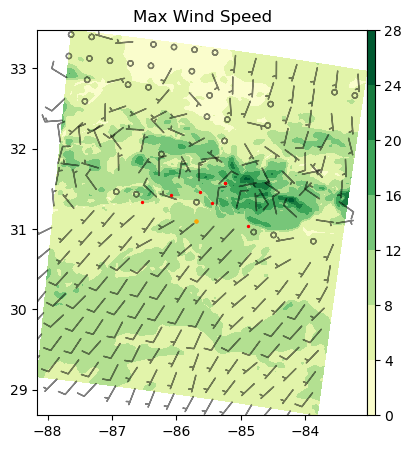

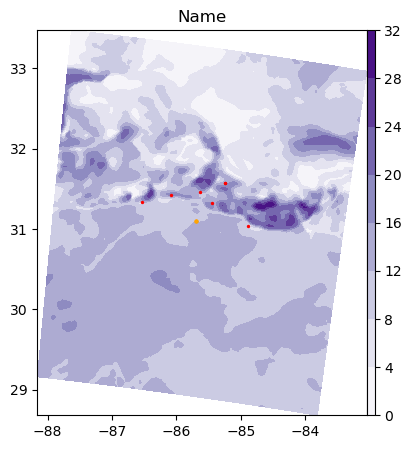

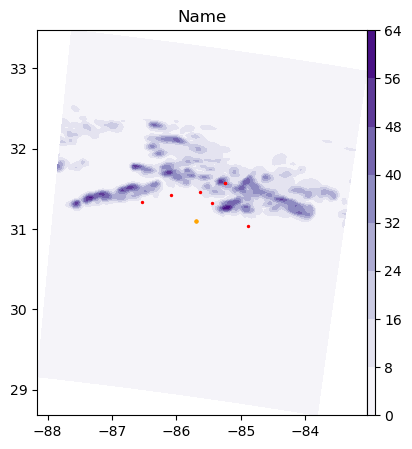

In [141]:
plot_interesting_events(event_2, filtered_data_2, forecast_hour=6, distance=1,time=.5)

2023-06-14 23:54:00 9


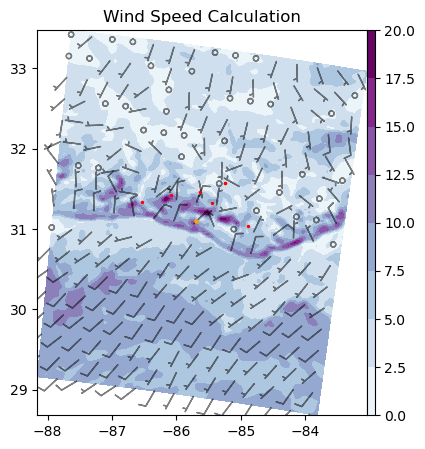

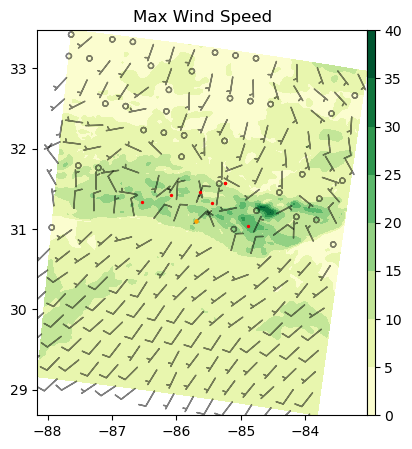

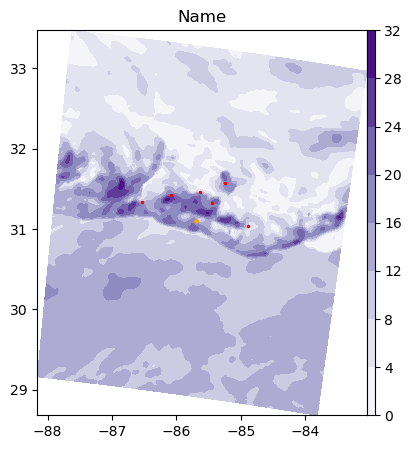

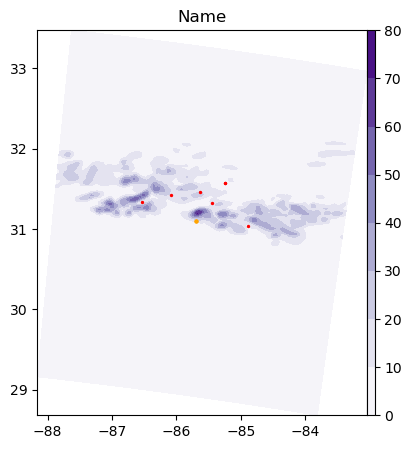

In [142]:
plot_interesting_events(event_2, filtered_data_2, forecast_hour=9, distance=1,time=.5)

## Interesting Report 3 ##

In [110]:
sc_report = wind_reports.loc[270]
sc_report

Speed                                                     UNK
Location                                         2 W Bluffton
County                                               Beaufort
State                                                      SC
Lat                                                     32.24
Lon                                                    -80.89
Comments    Report of a tree down near May River Rd and Li...
datetime                                  2023-06-15 00:10:00
Name: 270, dtype: object

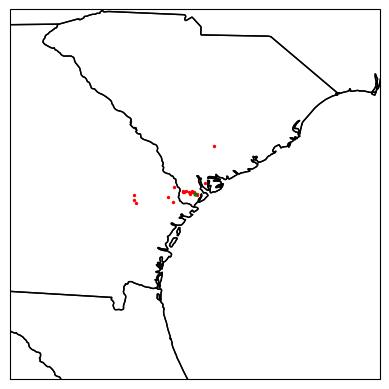

In [146]:
distance = 1
time = .5
sc_filtered_reports = filter_reports(wind_reports, sc_report, distance, time)
plot_storm_reports(sc_filtered_reports, sc_report, 3)

2023-06-15 00:10:00 3


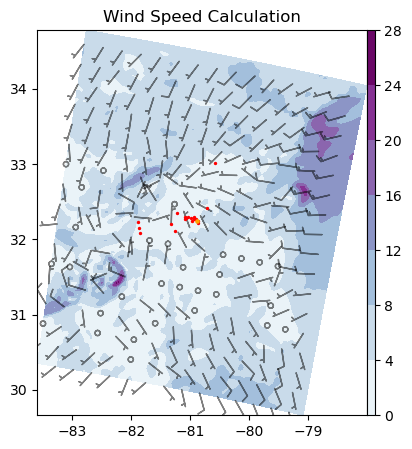

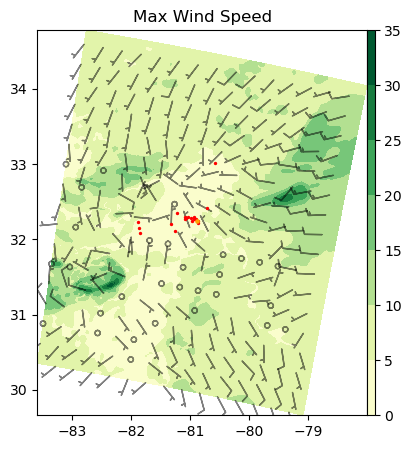

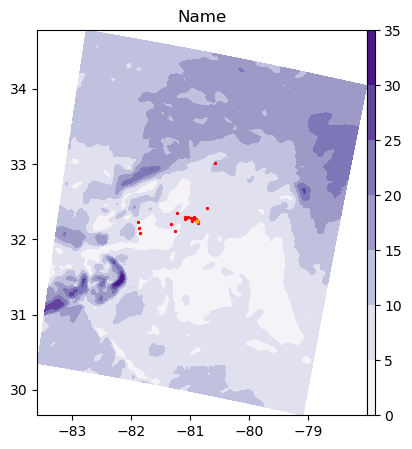

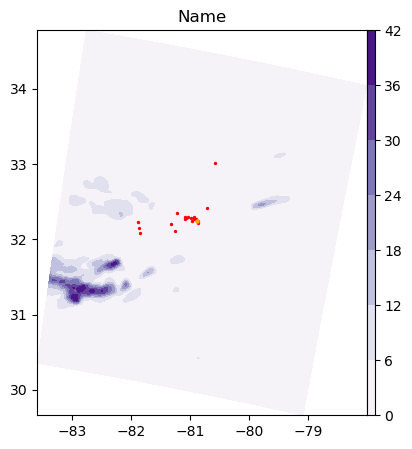

In [147]:
plot_interesting_events(sc_report, sc_filtered_reports, forecast_hour=3, distance=1,time=.5)

2023-06-15 00:10:00 6


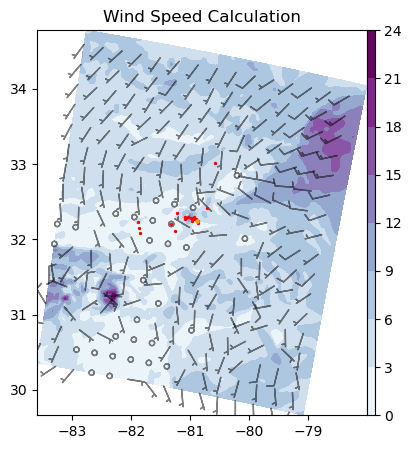

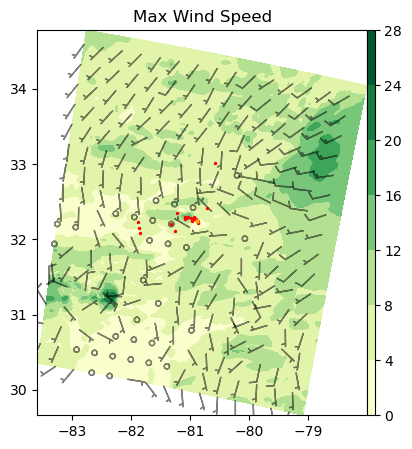

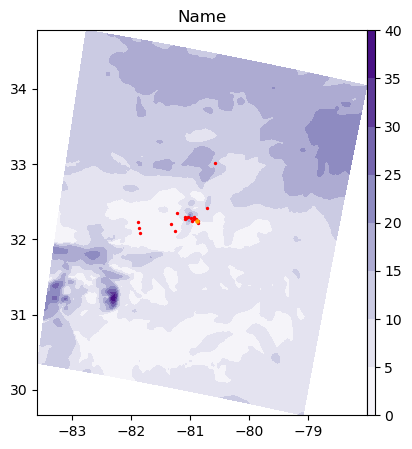

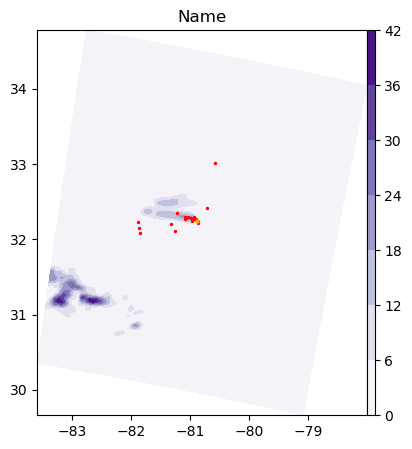

In [148]:
plot_interesting_events(sc_report, sc_filtered_reports, forecast_hour=6, distance=1,time=.5)

2023-06-15 00:10:00 9


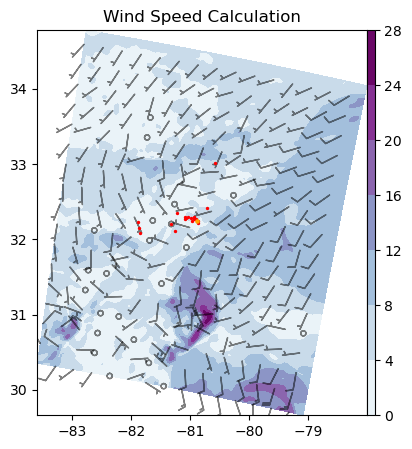

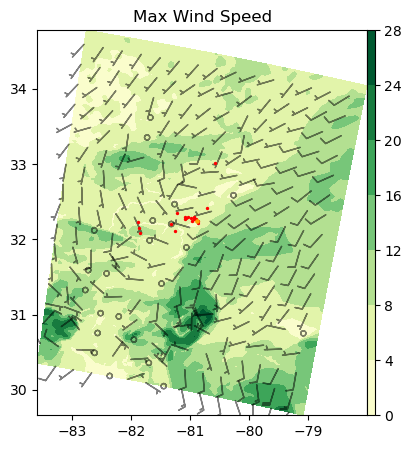

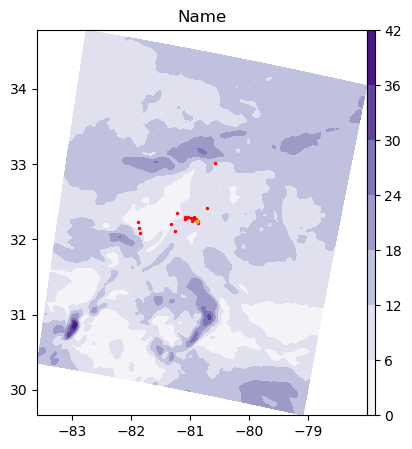

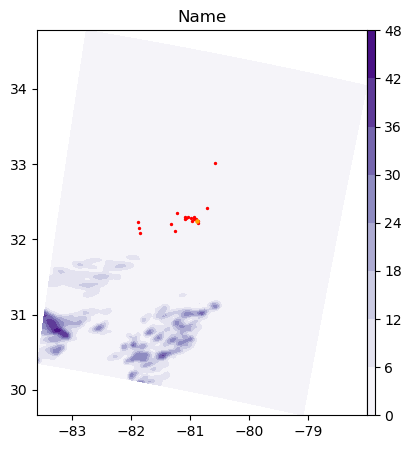

In [149]:
plot_interesting_events(sc_report, sc_filtered_reports, forecast_hour=9, distance=1,time=.5)

## 1.1 Texas Storm ##

In [65]:
tx_report = wind_reports.loc[32]
tx_report

Speed                                                     UNK
Location                                  5 ESE Phil Campbell
County                                               Franklin
State                                                      AL
Lat                                                     34.32
Lon                                                    -87.63
Comments    Trees and power lines were blown down along Ja...
datetime                                  2023-06-14 15:29:00
Name: 32, dtype: object

In [67]:
tx_filtered_reports = filter_reports(wind_reports, tx_report, 1, 1.5)
tx_filtered_reports

Speed             Location    County State    Lat    Lon  \
26   UNK        2 SSE Red Bay  Franklin    AL  34.40 -88.12   
32   UNK  5 ESE Phil Campbell  Franklin    AL  34.32 -87.63   
33   UNK         6 ENE Hodges  Franklin    AL  34.35 -87.83   

                                             Comments            datetime  
26  Trees and power lines were blown down along Hw... 2023-06-14 14:51:00  
32  Trees and power lines were blown down along Ja... 2023-06-14 15:29:00  
33  Trees and power lines were blown down at the i... 2023-06-14 15:29:00

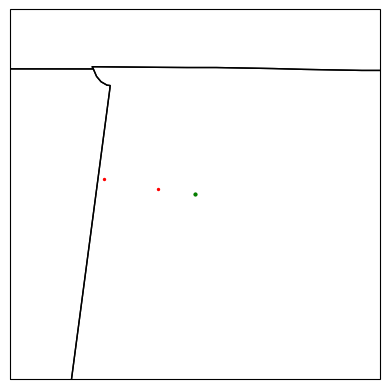

In [68]:
distance=1
hours=1.5
filtered_data_2 = filter_reports(wind_reports, tx_report, distance, hours)
plot_storm_reports(center_event=tx_report, events=tx_filtered_reports, distance=1)

1 Hour Forecast

2023-06-14 17:50:00 1


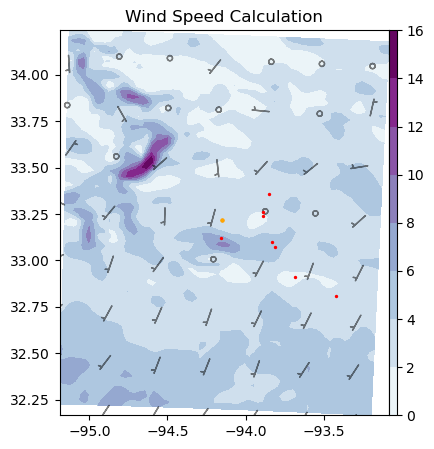

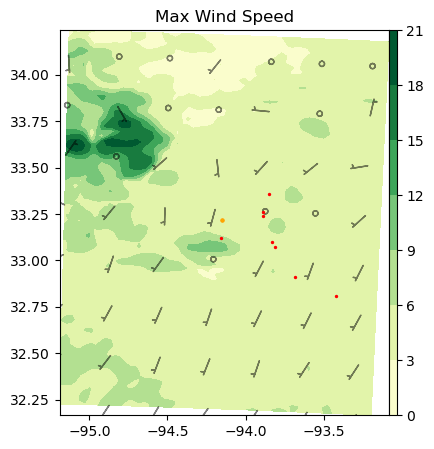

In [70]:
#1 Hour forecast
plot_interesting_events(tx_report, tx_filtered_reports, 1, 1)
# ds = fetch_rrfs_forecast(tx_report, 1)
# ds

3 Hour Forecast

2023-06-14 17:50:00 3


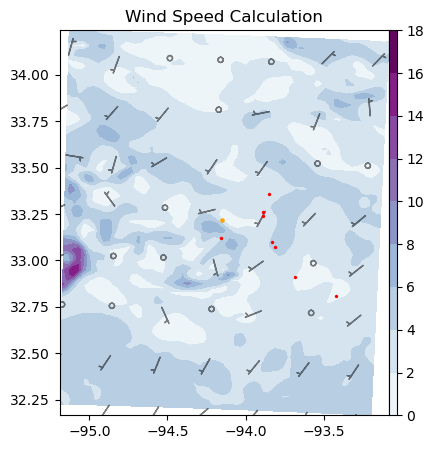

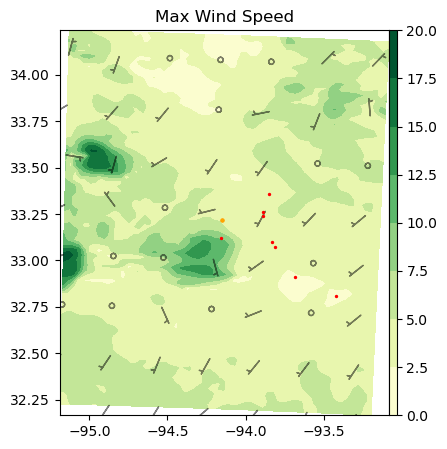

In [90]:
plot_interesting_events(tx_report, tx_filtered_reports, 3, 1)

6 Hours Forecast

2023-06-14 17:50:00 6
File succesfully downloaded


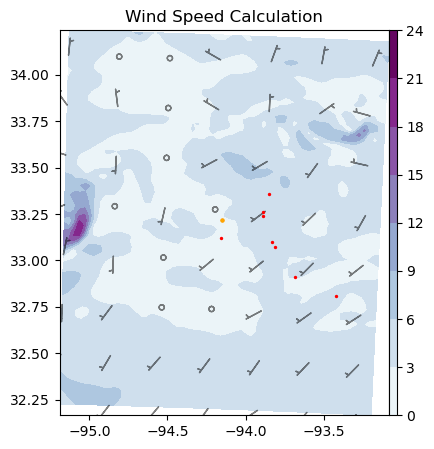

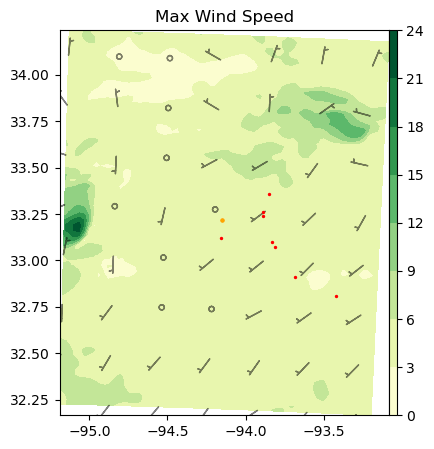

In [60]:
plot_interesting_events(tx_report, tx_filtered_reports, 6, 1)

9 Hour forecast

2023-06-14 17:50:00 9
File succesfully downloaded


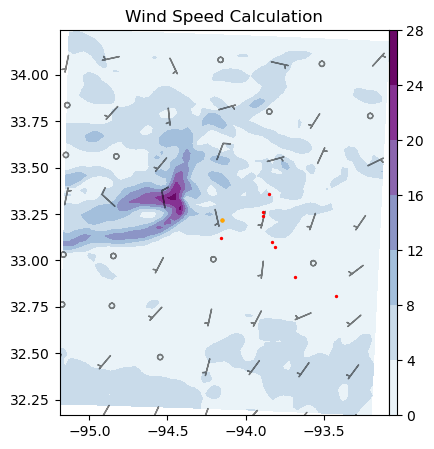

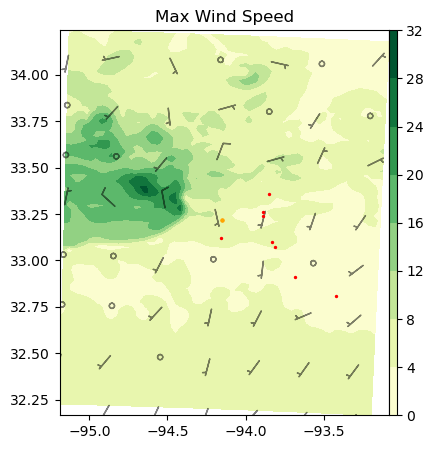

In [61]:
plot_interesting_events(tx_report, tx_filtered_reports, 9, 1)

## 1.3 GA Storm ##

In [45]:
ga_report = wind_reports.loc[26]
ga_report

Speed                                                  UNK
Location                                       3 SW Helena
County                                             Telfair
State                                                   GA
Lat                                                  32.04
Lon                                                 -82.96
Comments    Tree down at HWY 280 and Ken White Road. (FFC)
datetime                               2023-06-14 15:16:00
Name: 26, dtype: object

In [88]:
ga_filtered_events = filter_events(wind_reports, ga_report, 1, 1.5)
ga_filtered_events

Speed     Location   County State    Lat    Lon  \
26   UNK  3 SW Helena  Telfair    GA  32.04 -82.96   

                                          Comments            datetime  
26  Tree down at HWY 280 and Ken White Road. (FFC) 2023-06-14 15:16:00

2023-06-14 15:16:00 3


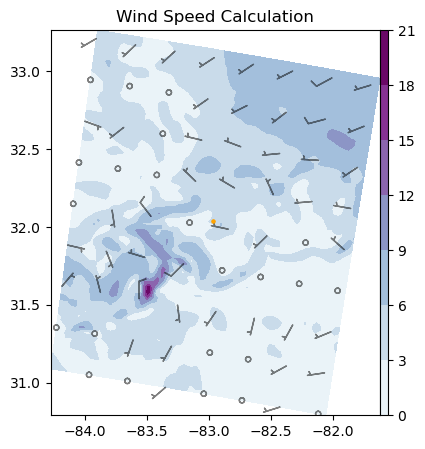

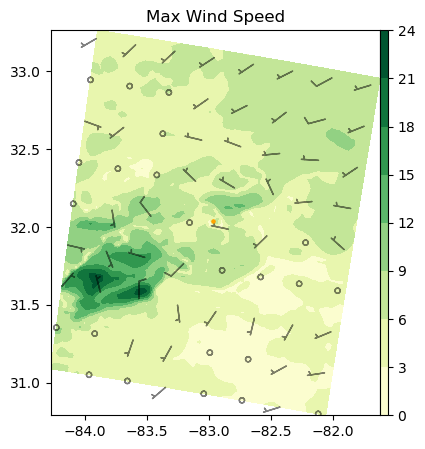

In [89]:
plot_interesting_events(ga_report, ga_filtered_events, 3, 1)

2023-06-14 15:16:00 6


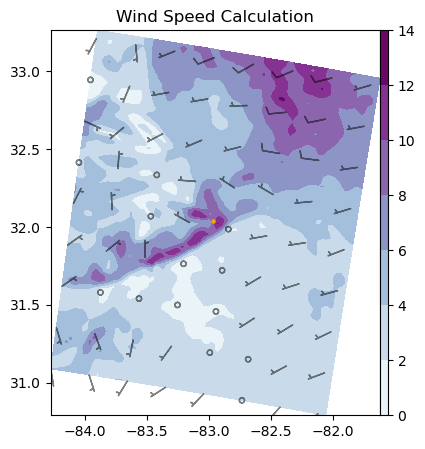

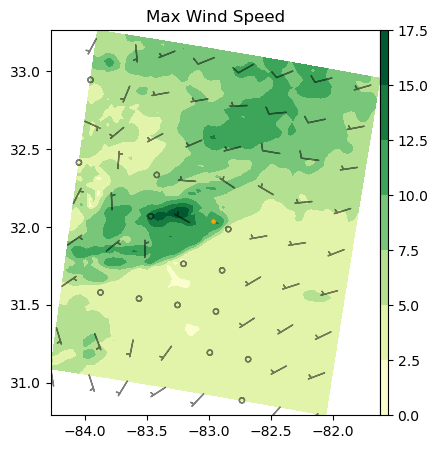

In [82]:
plot_interesting_events(ga_report, ga_filtered_events, 6, 1)

2023-06-14 15:16:00 9


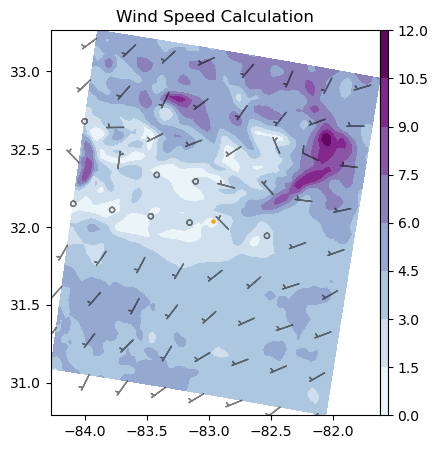

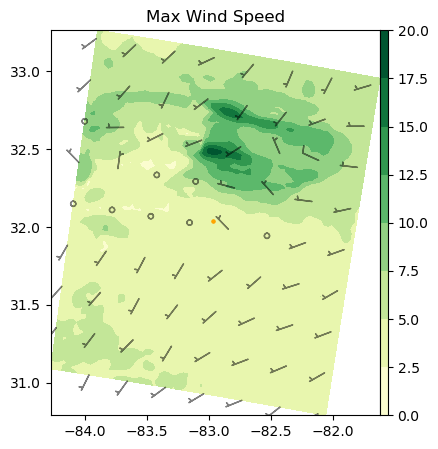

In [83]:
plot_interesting_events(ga_report, ga_filtered_events, 9, 1)

##  1.3 Alabama ##

In [44]:
al_report = wind_reports.loc[45]
al_report

Speed                                              UNK
Location                                    2 WSW Clay
County                                       Jefferson
State                                               AL
Lat                                              33.69
Lon                                             -86.63
Comments    Tree on a house on Dewey Heights Rd. (BMX)
datetime                           2023-06-14 18:45:00
Name: 45, dtype: object

In [75]:
al_filtered_events = filter_events(wind_reports, al_report, 1, 1.)
al_filtered_events

Speed                Location     County State    Lat    Lon  \
30   UNK  2 WNW Whitney Junction  St. Clair    AL  33.89 -86.33   
33   UNK               3 NE Lynn    Winston    AL  34.08 -87.51   
40   UNK          2 S Manchester     Walker    AL  33.87 -87.25   
42   UNK   2 NNE Village Springs     Blount    AL  33.79 -86.63   
43   UNK          2 N Smoke Rise     Blount    AL  33.91 -86.83   
44   UNK        2 NNE Smoke Rise     Blount    AL  33.90 -86.81   
45   UNK        1 ENE Smoke Rise     Blount    AL  33.89 -86.80   
46   UNK            1 NE Warrior  Jefferson    AL  33.83 -86.79   
47   UNK              2 WSW Clay  Jefferson    AL  33.69 -86.63   
49   UNK              1 ESE Argo  St. Clair    AL  33.69 -86.50   
51   UNK               Pell City  St. Clair    AL  33.59 -86.28   

                                             Comments            datetime  
30  Trees and power lines down on Crawford Cove Rd... 2023-06-14 17:45:00  
33                          Tree down on CR 25. (BMX) 2023-06-14 17:53:00  
40             Trees down on Walston Bridge Rd. (BMX) 2023-06-14 18:24:00  
42          Tree on vehicle on Red Valley Lane. (BMX) 2023-06-14 18:28:00  
43                     Trees down along HWY 31. (BMX) 2023-06-14 18:29:00  
44                RV overturned on Hallmark Rd. (BMX) 2023-06-14 18:30:00  
45  Trees and powerlines down on Rock Springs Rd. ... 2023-06-14 18:31:00  
46           Trees down on Warrior Trafford Rd. (BMX) 2023-06-14 18:36:00  
47         Tree on a house on Dewey Heights Rd. (BMX) 2023-06-14 18:45:00  
49    Tree blocking road on Briar Ridge Circle. (BMX) 2023-06-14 18:58:00  
51     Trees down across roadways in Pell City. (BMX) 2023-06-14 19:11:00

2023-06-14 18:45:00 1


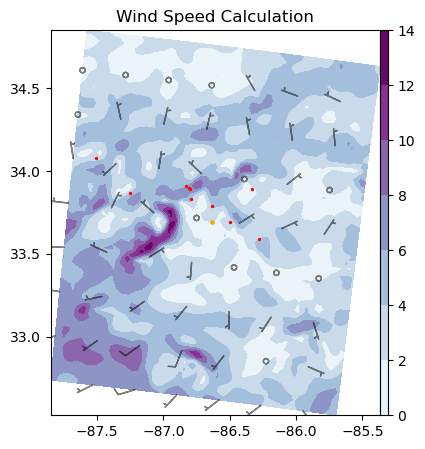

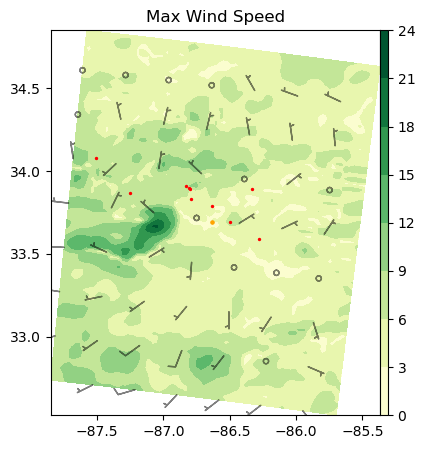

In [76]:
plot_interesting_events(al_report, al_filtered_events, 1, 1)

2023-06-14 18:45:00 3


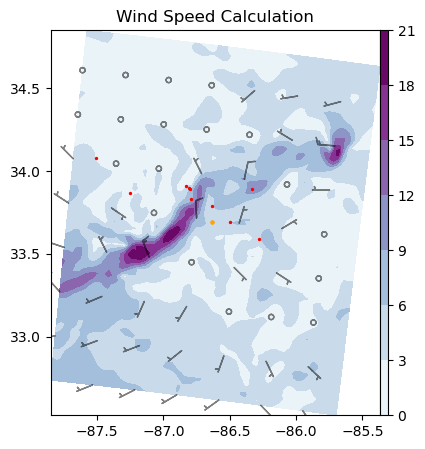

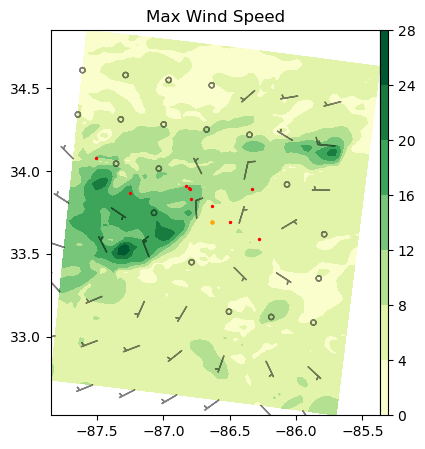

In [78]:
plot_interesting_events(al_report, al_filtered_events, 3, 1)

2023-06-14 18:45:00 6


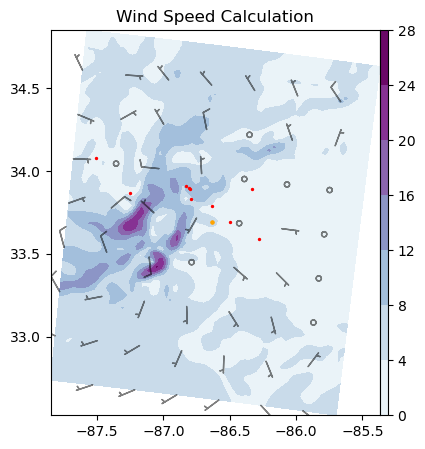

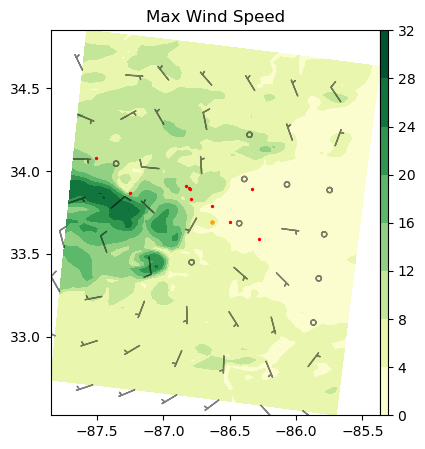

In [79]:
plot_interesting_events(al_report, al_filtered_events, 6, 1)

2023-06-14 18:45:00 9


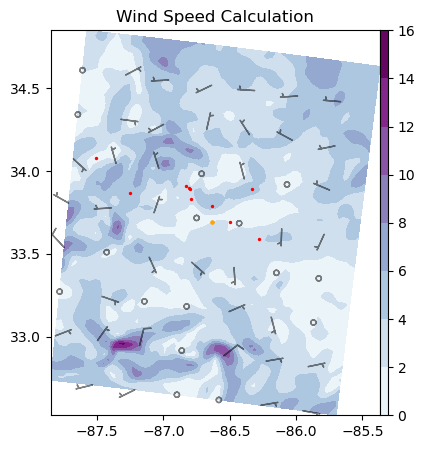

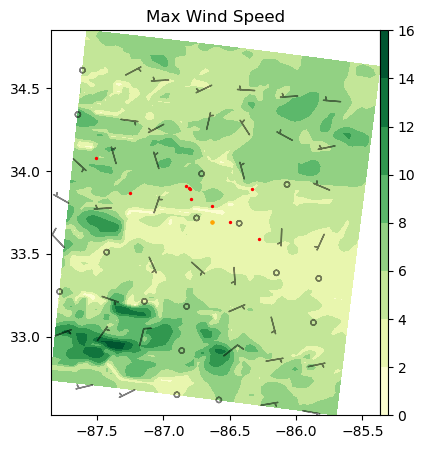

In [80]:
plot_interesting_events(al_report, al_filtered_events, 9, 1)

In [19]:
import matplotlib.pyplot as plt
import metpy.calc as mpcalc

def plot_max_wind_speed(ds, interesting_events, center_event, offset=3):

    # Calculate the total deformation of the flow
    wind_speed = mpcalc.wind_speed(ds.MAXUW_P8_L103_GLC0_max1h, ds.MAXVW_P8_L103_GLC0_max1h)
    # start figure and set axis
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # plot wind speed
    cf = ax.contourf(ds.coords['gridlon_0'], 
                     ds.coords['gridlat_0'], 
                     wind_speed, cmap=plt.cm.BuPu)
    plt.colorbar(cf, pad=0, aspect=50)
    ax.barbs(ds.coords['gridlon_0'][0::offset, 0::offset],
             ds.coords['gridlat_0'][0::offset, 0::offset],
             ds.UGRD_P0_L103_GLC0[0::offset, 0::offset], 
             ds.VGRD_P0_L103_GLC0[0::offset, 0::offset], 
             color='black', length=5, alpha=0.5)
   
    ax.set_title('Wind Speed Calculation')
    
    plt.scatter(
            x = interesting_events["Lon"],
            y = interesting_events["Lat"],
            color="red",
            s=2,
            alpha=1
        )
    
    plt.scatter(
        x=center_event["Lon"],
        y=center_event["Lat"],
        color="Orange",
        s=5
    )
    plt.show()



2023-06-14 18:15:00 3


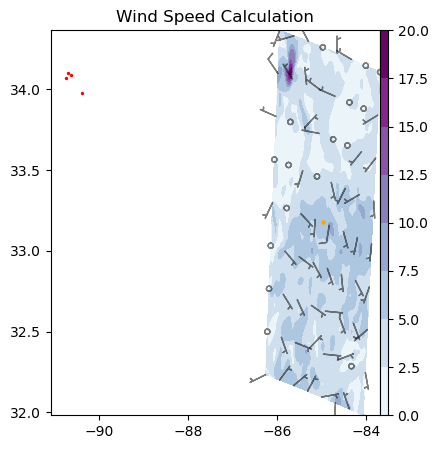

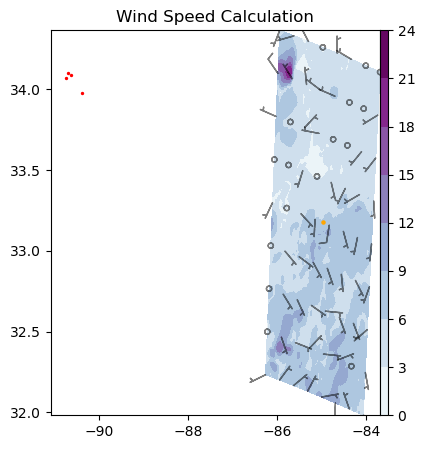

In [57]:
ga_report_2 = wind_reports.loc[34]
ga_filtered_events_2 = filter_events(wind_reports, ga_report, 1, 1.5)
plot_interesting_events(ga_report_2, ga_filtered_events_2, 3)

2023-06-14 14:26:00 6
File succesfully downloaded


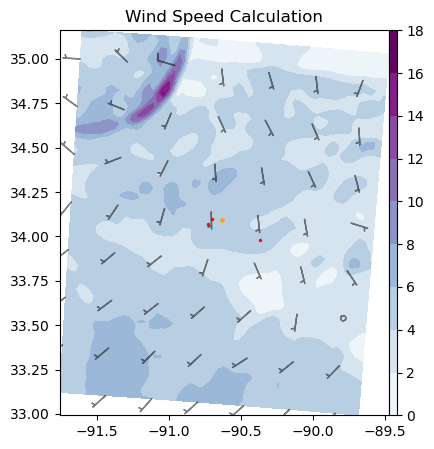

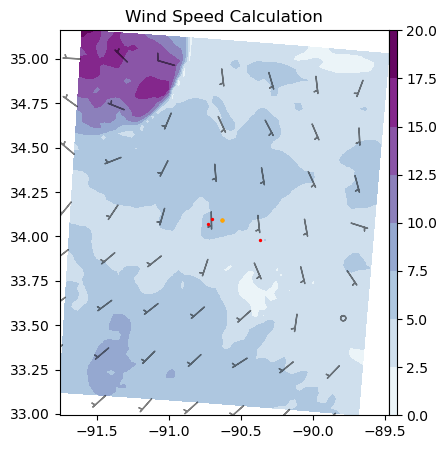

In [55]:
ga_report = wind_reports.loc[24]
ga_filtered_events = filter_events(wind_reports, ga_report)
plot_interesting_events(ga_report, ga_filtered_events, 6)

2023-06-14 14:26:00 9
File succesfully downloaded


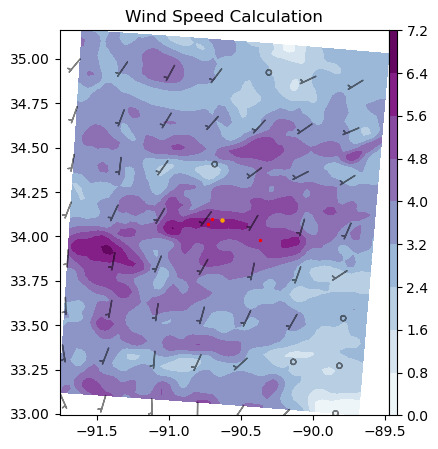

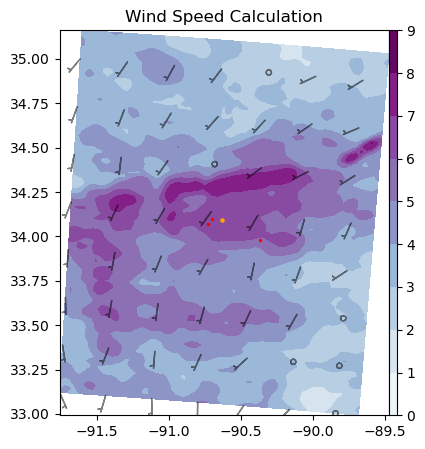

In [56]:
ga_report = wind_reports.loc[24]
ga_filtered_events = filter_events(wind_reports, ga_report)
plot_interesting_events(ga_report, ga_filtered_events, 9)

In [81]:
ds = fetch_rrfs_forecast(event_1, 3)

2023-06-14 22:59:00 3


In [82]:
ds.

<xarray.Dataset>
Dimensions:                          (ygrid_0: 1059, xgrid_0: 1799,
                                      lv_ISBL0: 5, lv_AMSL1: 10, lv_HYBL2: 65,
                                      lv_SPDL3: 6, lv_ISBL4: 4, lv_HTGL5: 2,
                                      lv_SIGL6: 22, lv_SPDL7: 3, lv_HTGL8: 2,
                                      lv_DBLL9: 9, lv_HTGL10: 2, lv_HTGL11: 2,
                                      lv_HTGL12: 2)
Coordinates:
  * lv_HTGL12                        (lv_HTGL12) float32 1.0 2.0
  * lv_SIGL6                         (lv_SIGL6) float32 0.053 0.158 ... 0.9975
  * lv_HTGL5                         (lv_HTGL5) float32 2.0 10.0
  * lv_ISBL4                         (lv_ISBL4) float32 2.5e+04 ... 8.5e+04
  * lv_HYBL2                         (lv_HYBL2) float32 1.0 2.0 ... 64.0 65.0
  * lv_AMSL1                         (lv_AMSL1) float32 305.0 ... 4.572e+03
  * lv_ISBL0                         (lv_ISBL0) float32 2.5e+04 ... 9.5e+04
    gridlat_0                        (ygrid_0, xgrid_0) float32 ...
    gridlon_0                        (ygrid_0, xgrid_0) float32 ...
Dimensions without coordinates: ygrid_0, xgrid_0, lv_SPDL3, lv_SPDL7, lv_HTGL8,
                                lv_DBLL9, lv_HTGL10, lv_HTGL11
Data variables: (12/217)
    TMP_P0_L1_GLC0                   (ygrid_0, xgrid_0) float32 ...
    TMP_P0_L3_GLC0                   (ygrid_0, xgrid_0) float32 ...
    TMP_P0_L7_GLC0                   (ygrid_0, xgrid_0) float32 ...
    TMP_P0_L100_GLC0                 (lv_ISBL0, ygrid_0, xgrid_0) float32 ...
    TMP_P0_L102_GLC0                 (lv_AMSL1, ygrid_0, xgrid_0) float32 ...
    TMP_P0_L103_GLC0                 (ygrid_0, xgrid_0) float32 ...
    ...                               ...
    lv_HTGL8_l0                      (lv_HTGL8) float32 ...
    lv_SPDL7_l1                      (lv_SPDL7) float32 ...
    lv_SPDL7_l0                      (lv_SPDL7) float32 ...
    lv_SPDL3_l1                      (lv_SPDL3) float32 ...
    lv_SPDL3_l0                      (lv_SPDL3) float32 ...
    gridrot_0                        (ygrid_0, xgrid_0) float32 ...

In [91]:
def plot_gust_potential(ds, interesting_events, center_event, offset=3):
    #Plots the max wind speed variable
    # Calculate the total deformation of the flow
    # wind_speed = mpcalc.wind_speed(ds.MAXUW_P8_L103_GLC0_max1h, ds.MAXVW_P8_L103_GLC0_max1h)
    # start figure and set axis
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # plot wind speed
    cf = ax.contourf(ds.coords['gridlon_0'], 
                     ds.coords['gridlat_0'], 
                     ds.GUST_P0_L1_GLC0, cmap=plt.cm.YlGn)
    plt.colorbar(cf, pad=0, aspect=50)
    ax.set_title('Gust Potential')
    
    plt.scatter(
            x = interesting_events["Lon"],
            y = interesting_events["Lat"],
            color="red",
            s=2,
            alpha=1
        )
    
    plt.scatter(
        x=center_event["Lon"],
        y=center_event["Lat"],
        color="Orange",
        s=5
    )
    plt.show()
    

## June 15 ##

In [160]:
june_15_reports = get_wind_report(pd.Timestamp(year=2023, month=6, day=15))

In [174]:
interesting_events(june_15_reports)

1 2
2 2
3 3
4 4
5 2
6 2
7 4
8 6
9 4
10 6
11 3
12 4
13 3
14 7
15 7
16 7
17 7
18 2
19 8
20 8
21 3
22 2
23 8
24 7
25 6
26 1
27 8
28 17
29 10
30 16
31 14
32 14
33 16
34 14
35 14
36 7
37 15
38 5
39 13
40 7
41 14
42 4
43 13
44 4
45 13
46 13
47 14
48 13
49 13
50 13
51 5
52 13
53 16
54 13
55 13
56 12
57 16
58 20
59 18
60 27
61 24
62 26
63 27
64 27
65 27
66 27
67 4
68 25
69 25
70 5
71 16
72 5
73 16
74 27
75 2
76 5
77 16
78 16
79 2
80 16
81 16
82 5
83 18
84 18
85 9
86 27
87 27
88 18
89 27
90 18
91 14
92 12
93 13
94 13
95 27
96 8
97 33
98 31
99 11
100 27
101 31
102 31
103 30
104 28
105 1
106 2
107 26
108 26
109 5
110 25
111 5
112 5
113 25
114 5
115 12
116 26
117 8
118 10
119 12
120 11
121 10
122 10
123 3
124 10
125 3
126 3
127 1
128 13
129 13
130 21
131 8
132 10
133 6
134 14
135 13
136 12
137 13
138 14
139 17
140 12
141 11
142 7
143 12
144 3
145 9
146 14
147 16
148 11
149 16
150 1
151 19
152 9
153 18
154 18
155 1
156 16
157 18
158 19
159 7
160 6
161 11
162 17
163 3
164 18
165 2
166 18
167 17
168 

[Speed                             UNK
 Location             2 SW Williamston
 County                       Anderson
 State                              SC
 Lat                              34.6
 Lon                             -82.5
 Comments    Several trees down. (GSP)
 datetime          2023-06-15 22:02:00
 Name: 59, dtype: object,
 Speed                                                     UNK
 Location                                    4 WNW Harbor View
 County                                                  Lucas
 State                                                      OH
 Lat                                                     41.72
 Lon                                                    -83.52
 Comments    Multiple utility poles down and report of a ro...
 datetime                                  2023-06-15 22:07:00
 Name: 60, dtype: object,
 Speed                                                     UNK
 Location                                    3 WNW Harbor View
 Count

In [161]:
june_15_reports[june_15_reports["Lat"] == 33.03]

Speed Location  County State    Lat    Lon  \
169   UNK    Lavon  Collin    TX  33.03 -96.44   
170    78    Lavon  Collin    TX  33.03 -96.44   

                                              Comments            datetime  
169  Several trees down and structural damage repor... 2023-06-16 03:50:00  
170     EM reports 78mph gust measured in Lavon. (FWD) 2023-06-16 03:52:00

In [185]:
event = june_15_reports.loc[278]
event

Speed                                          UNK
Location                              1 ENE Cleary
County                                      Rankin
State                                           MS
Lat                                          32.17
Lon                                         -90.17
Comments    Tree downed on Cleary Church Rd. (JAN)
datetime                       2023-06-16 10:18:00
Name: 278, dtype: object

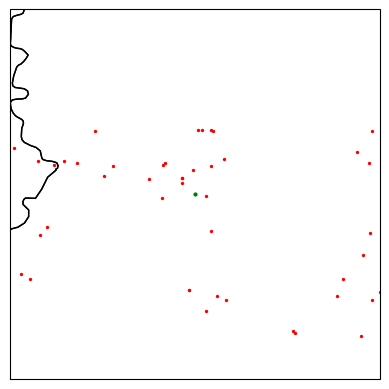

In [186]:
distance=1
hours=1.5
filtered_data = filter_reports(june_15_reports, event, distance, hours)
plot_storm_reports(center_event=event, events=filtered_data, distance=1)

2023-06-16 10:18:00 3
File succesfully downloaded


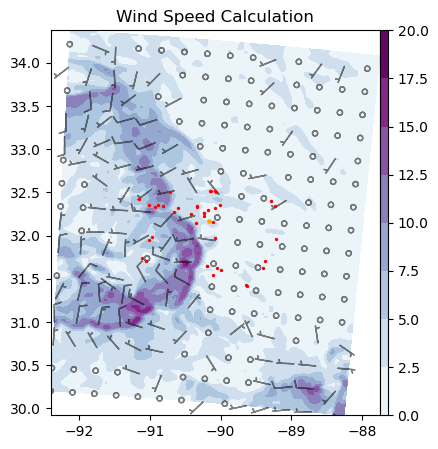

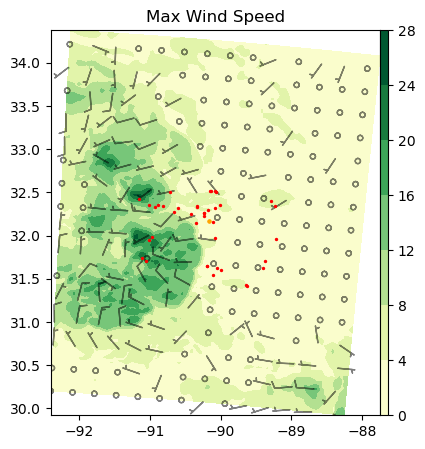

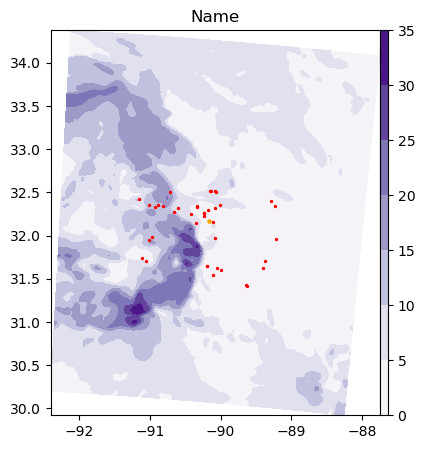

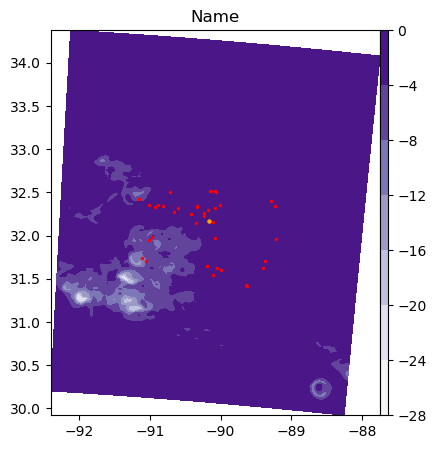

In [187]:
plot_interesting_events(event, filtered_data, 3, 1, 1)

In [ ]:
plot_interesting_events(event, filtered_data, , 1, 1)


In [55]:
#Class that represents individual slice
class spatial_slice:
    def __init__(self, df, center, bounding_box, bin_start, bin_size):
        self.df = df #pandas dataframe with reports
        self.center = center #Report used as center for slice
        self.bounding_box = bounding_box #Shapely object
        #Metadata 
        self.bin_start = bin_start #Date time of bin start
        self.bin_size = bin_size #Number of hours in bin

    def plot_slice(self):

        extent = 2
        figure = plt.figure()
    
        ax = figure.add_subplot(1,1,1,projection=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.STATES)
        ax.set_extent(
            [self.center["Lon"] - extent, 
             self.center["Lon"] + extent, 
             self.center["Lat"] - extent, 
            self.center["Lat"] + extent],
            crs=ccrs.PlateCarree()
        )
        ax.scatter(
            x = self.df["Lon"],
            y = self.df["Lat"],
            color="red",
            s=2,
            alpha=1,
            transform=ccrs.PlateCarree()
        )
        
        ax.scatter(
            x = self.center["Lon"],
            y = self.center["Lat"],
            color="green",
            s=4,
            alpha=1,
            transform=ccrs.PlateCarree()
        )

        x,y = self.bounding_box.exterior.xy
        ax.plot(x,y, transform=ccrs.PlateCarree())
        plt.show()
        return 

In [92]:
#Generates the slices for reports in a given timebin
def get_slices(time_bin_df, bin_start, bin_size):
    slices = []
    #TODO: Algorithm to generate slices can be better
    while time_bin_df.size > 0:
        #Algorithm arbitratily chooses first report as center for the slice
        center = time_bin_df.loc[0]
        #Spatially filters dataframe
        data = spatial_filter(time_bin_df, center["Lat"], center["Lon"], distance=1)
        #Gets a bounding box
        bounding_box = get_bounding_box(center, 0.5)
        slice = spatial_slice(data, center, bounding_box, bin_start, bin_size)
        slices.append(slice)
        #Removes from df the reports that are in current slice
        time_bin_df = time_bin_df[~time_bin_df.index.isin(slice.df.index)]
        #Resets index so the loop works
        time_bin_df = time_bin_df.reset_index(drop=True)
        
    return slices


In [93]:
#Adds time bin column to each daily report
def add_time_bins(daily_reports, day_datetime, bin_size=3):
    
    hourly_bins = make_time_bins(day_datetime, bin_size)
    bins = []
    
    #For each report, 
    for row in daily_reports.iterrows():
        
        bins.append(get_bin(row[1], hourly_bins, bin_size))
    daily_reports["bins"] = bins

    return daily_reports

#Returns the correct bin for a given row 
def get_bin(report, hourly_bins, bin_size):
    time = report["datetime"]
    for bin in hourly_bins:
        if time.hour - bin.hour < bin_size:
            return bin
    return 

#Helper functions

#Generates the time bins
def make_time_bins(day_datetime, bin_size):
    start = pd.Timestamp(year=day_datetime.year, month=day_datetime.month, day=day_datetime.day, hour=0)
    end = pd.Timestamp(year=day_datetime.year, month=day_datetime.month, day=day_datetime.day, hour=23)
    return pd.date_range(start, end, freq=f'{bin_size}H')
    # return 
    
#Returns bounding box shapely object centered on center event
def get_bounding_box(center_event, size):
    lat = center_event["Lat"]
    lon = center_event["Lon"]
    b = shapely.box(lon - size, lat - size, lon + size, lat + size)
    return b


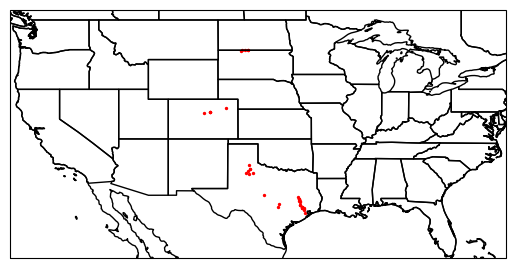

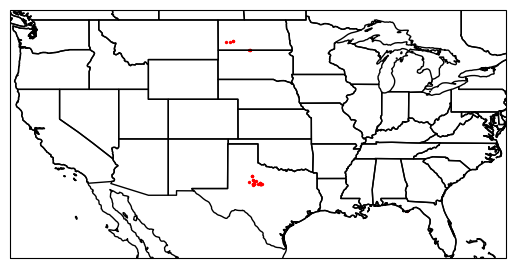

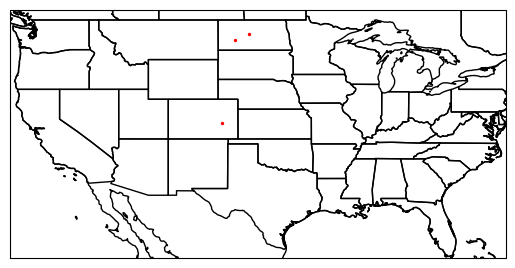

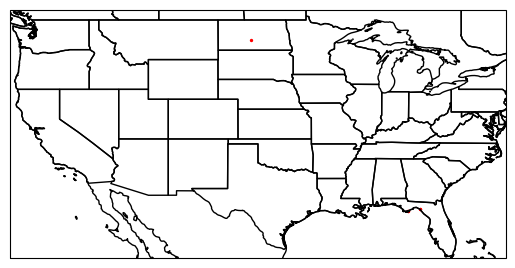

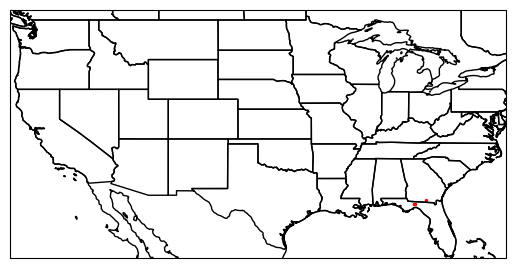

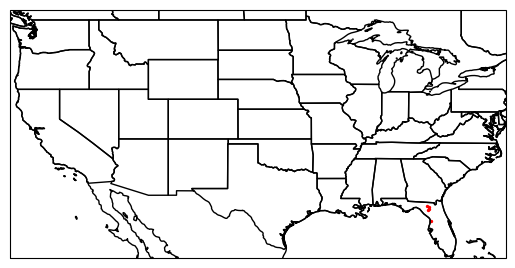

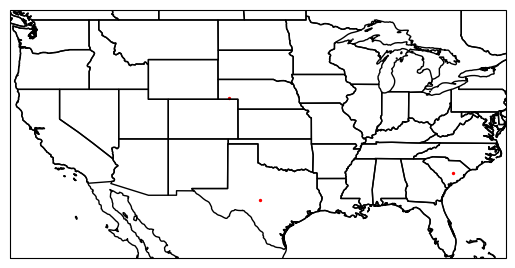

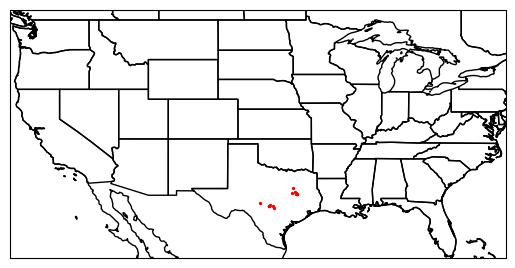

In [95]:
day = pd.Timestamp(year = 2023, month=6, day=21)
time_bins = make_time_bins(day, bin_size=3)
#Fetches reports for that day
daily_reports = get_wind_report(day)
#adds time bin column to daily reports
daily_reports = add_time_bins(daily_reports, day)
#Reports grouped by time bin
g_daily_reports = daily_reports.groupby(by=["bins"])
#For each time bin
for b in time_bins:
    events = g_daily_reports.get_group(b)
    plot_storm_reports(events)

Lat                                               \
                    count       mean       std    min      25%     50%   
bins                                                                     
2023-06-21 00:00:00  40.0  34.102750  5.515240  29.52  30.1700  30.965   
2023-06-21 03:00:00  40.0  34.948750  5.400242  29.72  32.4575  32.490   
2023-06-21 06:00:00   3.0  44.363333  5.010083  38.59  42.7600  46.930   
2023-06-21 09:00:00   5.0  33.228000  7.671390  29.70  29.7100  29.890   
2023-06-21 12:00:00   4.0  30.557500  0.161735  30.47  30.4775  30.480   
2023-06-21 15:00:00   5.0  29.798000  0.591456  28.78  29.8600  29.950   
2023-06-21 18:00:00   3.0  35.206667  5.305698  30.89  32.2450  33.600   
2023-06-21 21:00:00  15.0  30.972667  0.699750  30.05  30.2800  31.460   

                                     Lon                                 \
                        75%    max count        mean        std     min   
bins                                                                      
2023-06-21 00:00:00  35.685  45.99  40.0  -98.599000   3.357638 -105.49   
2023-06-21 03:00:00  32.945  46.88  40.0 -100.107750   2.594271 -103.20   
2023-06-21 06:00:00  47.250  47.57   3.0 -102.266667   1.335527 -103.58   
2023-06-21 09:00:00  29.890  46.95   5.0  -87.540000   7.372879 -100.68   
2023-06-21 12:00:00  30.560  30.80   4.0  -83.935000   0.594222  -84.28   
2023-06-21 15:00:00  30.120  30.28   5.0  -82.788000   0.152709  -82.96   
2023-06-21 18:00:00  37.365  41.13   3.0  -94.353333  12.266028 -102.97   
2023-06-21 21:00:00  31.495  32.09  15.0  -97.462667   1.409323  -99.76   

                                                         
                          25%      50%      75%     max  
bins                                                     
2023-06-21 00:00:00 -101.0175  -96.930  -95.560  -95.24  
2023-06-21 03:00:00 -100.5700 -100.400  -99.810  -85.03  
2023-06-21 06:00:00 -102.9450 -102.310 -101.610 -100.91  
2023-06-21 09:00:00  -84.8900  -84.890  -83.620  -83.62  
2023-06-21 12:00:00  -84.2800  -84.205  -83.860  -83.05  
2023-06-21 15:00:00  -82.8700  -82.790  -82.770  -82.55  
2023-06-21 18:00:00 -101.3750  -99.780  -90.045  -80.31  
2023-06-21 21:00:00  -98.8500  -96.540  -96.135  -96.06

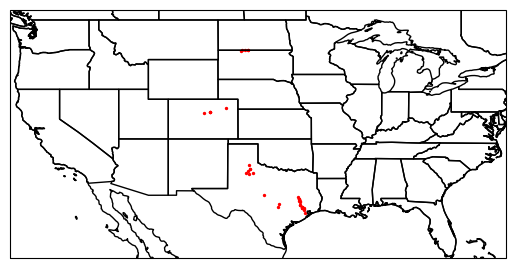

In [96]:
events = g_daily_reports.get_group(hourly_bins[0])
plot_storm_reports(events)

In [20]:
hourly_bins[1]

Timestamp('2023-06-21 03:00:00', freq='3H')

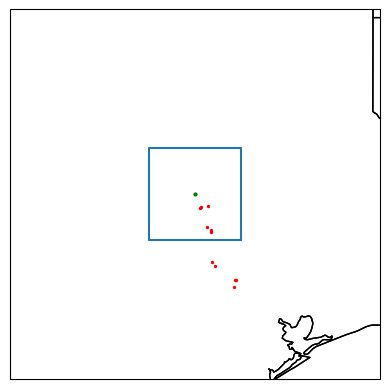

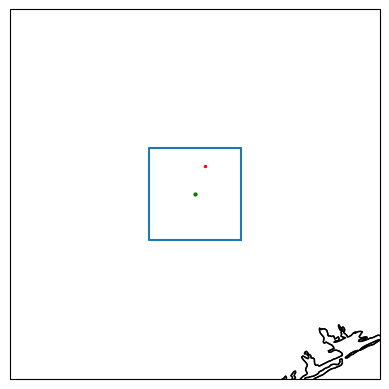

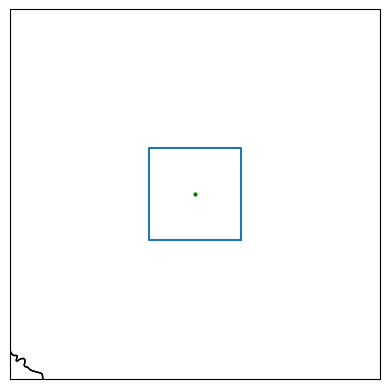

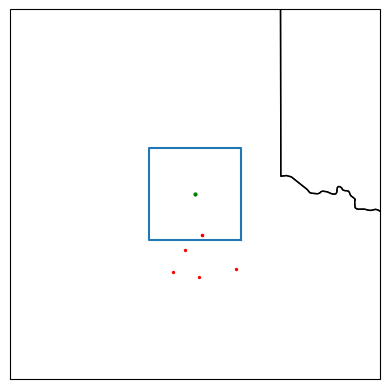

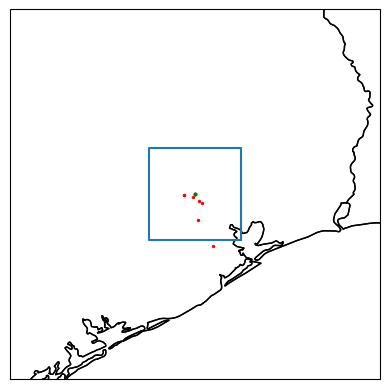

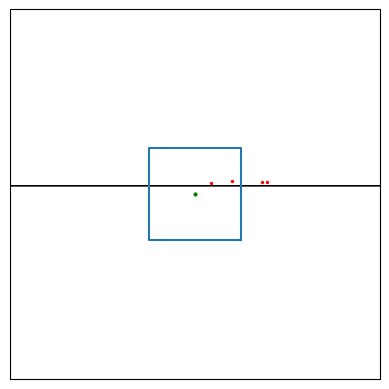

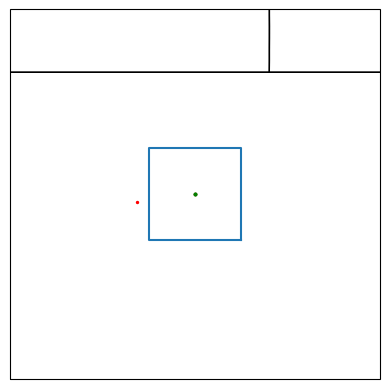

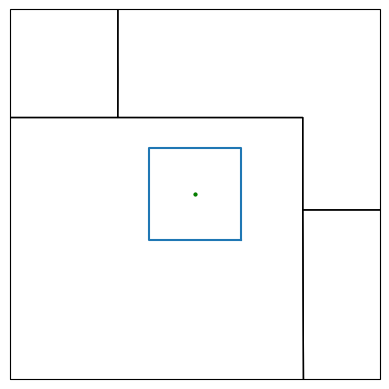

In [ ]:
events = events.reset_index(drop=True)
bin_size = 3
slices = get_slices(events,hourly_bins[1], bin_size)
for slice in slices:
    slice.plot_slice()

In [31]:
init_time = hourly_bins[0] - pd.Timedelta(hours=6)
hour = 6
dt_list = r.fetch_model_outputs(init_time, [hour, hour + 1, hour+2])

Finished downloading


In [32]:
dt_list[0]

<xarray.Dataset>
Dimensions:                          (ygrid_0: 1059, xgrid_0: 1799,
                                      lv_ISBL0: 5, lv_AMSL1: 10, lv_HYBL2: 65,
                                      lv_SPDL3: 6, lv_ISBL4: 4, lv_HTGL5: 2,
                                      lv_SIGL6: 22, lv_SPDL7: 3, lv_HTGL8: 2,
                                      lv_DBLL9: 9, lv_HTGL10: 2, lv_HTGL11: 2,
                                      lv_HTGL12: 2)
Coordinates:
  * lv_HTGL12                        (lv_HTGL12) float32 1.0 2.0
  * lv_SIGL6                         (lv_SIGL6) float32 0.053 0.158 ... 0.9975
  * lv_HTGL5                         (lv_HTGL5) float32 2.0 10.0
  * lv_ISBL4                         (lv_ISBL4) float32 2.5e+04 ... 8.5e+04
  * lv_HYBL2                         (lv_HYBL2) float32 1.0 2.0 ... 64.0 65.0
  * lv_AMSL1                         (lv_AMSL1) float32 305.0 ... 4.572e+03
  * lv_ISBL0                         (lv_ISBL0) float32 2.5e+04 ... 9.5e+04
    gridlat_0                        (ygrid_0, xgrid_0) float32 ...
    gridlon_0                        (ygrid_0, xgrid_0) float32 ...
Dimensions without coordinates: ygrid_0, xgrid_0, lv_SPDL3, lv_SPDL7, lv_HTGL8,
                                lv_DBLL9, lv_HTGL10, lv_HTGL11
Data variables: (12/217)
    TMP_P0_L1_GLC0                   (ygrid_0, xgrid_0) float32 ...
    TMP_P0_L3_GLC0                   (ygrid_0, xgrid_0) float32 ...
    TMP_P0_L7_GLC0                   (ygrid_0, xgrid_0) float32 ...
    TMP_P0_L100_GLC0                 (lv_ISBL0, ygrid_0, xgrid_0) float32 ...
    TMP_P0_L102_GLC0                 (lv_AMSL1, ygrid_0, xgrid_0) float32 ...
    TMP_P0_L103_GLC0                 (ygrid_0, xgrid_0) float32 ...
    ...                               ...
    lv_HTGL8_l0                      (lv_HTGL8) float32 ...
    lv_SPDL7_l1                      (lv_SPDL7) float32 ...
    lv_SPDL7_l0                      (lv_SPDL7) float32 ...
    lv_SPDL3_l1                      (lv_SPDL3) float32 ...
    lv_SPDL3_l0                      (lv_SPDL3) float32 ...
    gridrot_0                        (ygrid_0, xgrid_0) float32 ...

In [77]:
def get_surrogate_reports(dt_list, threshold):
    surrogate_reports_list = []
    for i in range(len(dt_list)):
        test_d = xr.Dataset(
            data_vars=dict(
                wind=(["ygrid_0", "xgrid_0"], 
                      ((dt_list[i].MAXUW_P8_L103_GLC0_max1h.data)**2 + (dt_list[i].MAXUW_P8_L103_GLC0_max1h.data)**2)**(1/2))
            ),
            coords=dict(
                gridlat_0=(["ygrid_0", "xgrid_0"], dt_list[i].coords['gridlat_0'].data),
                gridlon_0=(["ygrid_0", "xgrid_0"], dt_list[i].coords['gridlon_0'].data)
            )
        )

        t_df = test_d.where(test_d.wind > threshold, drop=True)
        t_df = t_df.to_dataframe().reset_index()
        t_df = pd.DataFrame({'wind':t_df['wind'], 'Lat': t_df['gridlat_0'], 'Lon': t_df['gridlon_0']})
        surrogate_reports = t_df.dropna().reset_index()
        surrogate_reports_list.append(surrogate_reports)
    return surrogate_reports_list

In [78]:
surrogate_list = get_surrogate_reports(dt_list, threshold = 30)

In [79]:
surrogate_list

[     index       wind        Lat         Lon
 0       75  30.817816  23.056923  -74.373199
 1       76  30.729427  23.050438  -74.345764
 2      156  31.171370  23.088650  -74.393600
 3      157  34.353352  23.082170  -74.366158
 4      158  33.734631  23.075684  -74.338707
 ..     ...        ...        ...         ...
 247   5461  35.060455  45.673901 -100.494354
 248   5542  34.441738  45.699772 -100.533897
 249   5543  33.027523  45.700645 -100.495605
 250   5624  30.110708  45.726513 -100.535156
 251   5625  30.022322  45.727390 -100.496849
 
 [252 rows x 4 columns],
      index       wind        Lat         Lon
 0       98  31.104536  23.101587  -74.448509
 1      200  30.220652  23.126846  -74.441483
 2      304  30.927759  24.693138  -73.640228
 3      305  31.104536  24.686407  -73.612312
 4      405  30.220652  24.725231  -73.660751
 ..     ...        ...        ...         ...
 256   6155  31.562803  44.135864 -105.220802
 257   6156  30.855696  44.138107 -105.183533
 258   

In [80]:
surrogate_df = pd.concat(surrogate_list)
surrogate_df = surrogate_df.reset_index(drop=True)
surrogate_df

index       wind        Lat         Lon
0       75  30.817816  23.056923  -74.373199
1       76  30.729427  23.050438  -74.345764
2      156  31.171370  23.088650  -74.393600
3      157  34.353352  23.082170  -74.366158
4      158  33.734631  23.075684  -74.338707
..     ...        ...        ...         ...
971   5065  31.221085  44.281639 -104.560974
972   5069  32.104969  44.289780 -104.411446
973   5070  34.314678  44.291786 -104.374062
974   5071  33.695957  44.293785 -104.336670
975   5168  31.044308  44.320545 -104.339455

[976 rows x 4 columns]

In [27]:
def evaluate_model_on_time_bin(slices, bin_start, bin_size, lead_time):
    initialization_date = bin_start - pd.Timedelta(hours=lead_time)
    model_outputs = r.fetch_model_outputs(initialization_date, [lead_time, lead_time + 1, lead_time + 2])
    
    return

In [178]:
# threshold = 30
# a = test_d.where(test_d.wind > threshold, drop=True)
# df = a.to_dataframe().reset_index()
# salu2 = pd.DataFrame({'wind':df['wind'], 'Lat': df['gridlat_0'], 'Lon': df['gridlon_0']})
# surrogate_reports = salu2.dropna().reset_index()

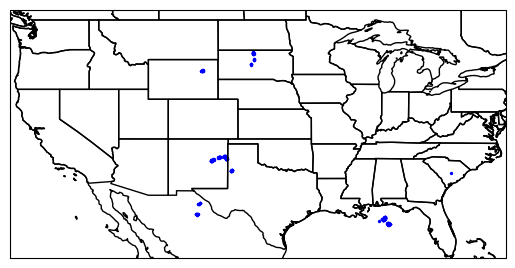

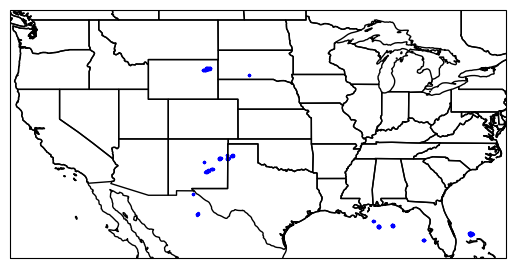

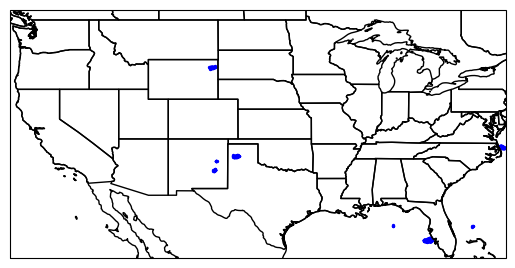

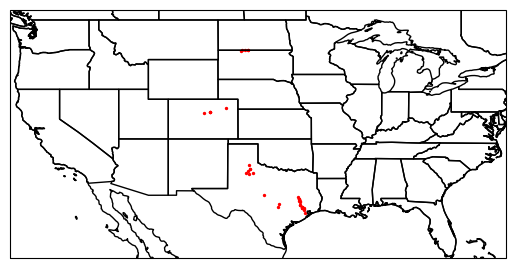

In [82]:
for i in range(len(surrogate_list)):
    plot_storm_reports(surrogate_list[i], surrogate=True)
plot_storm_reports(events)

In [67]:
surrogate_df.

AttributeError: 'DataFrame' object has no attribute 'rows'

In [83]:
surrogate_df.index = pd.RangeIndex.from_range(range(len(surrogate_df.index)))


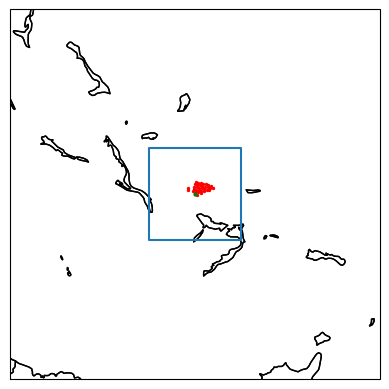

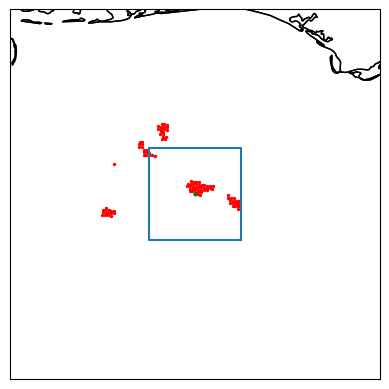

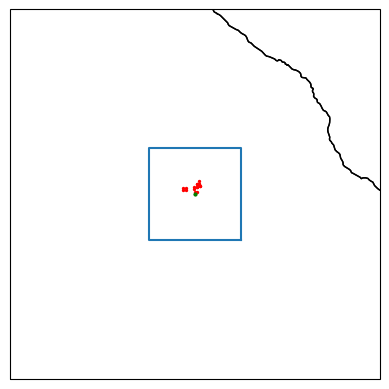

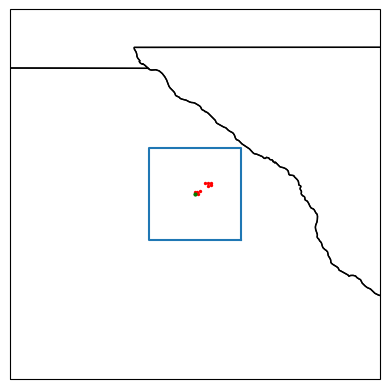

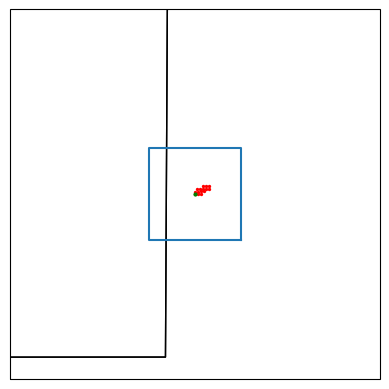

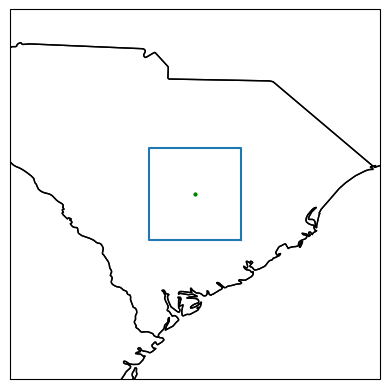

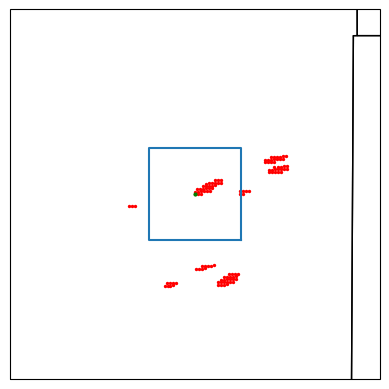

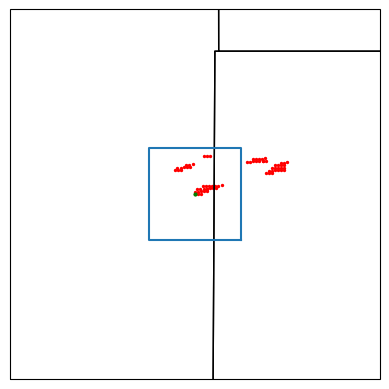

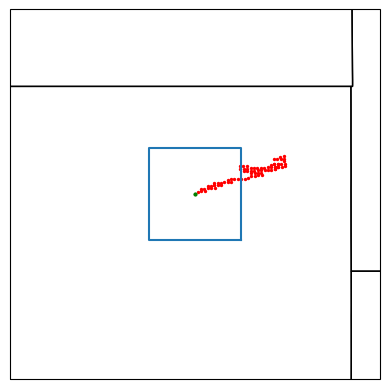

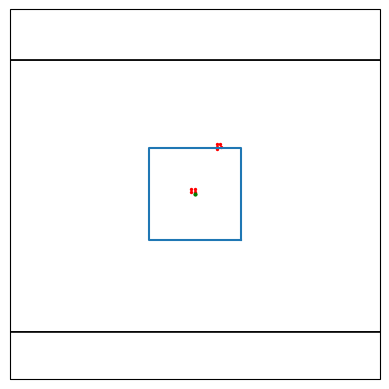

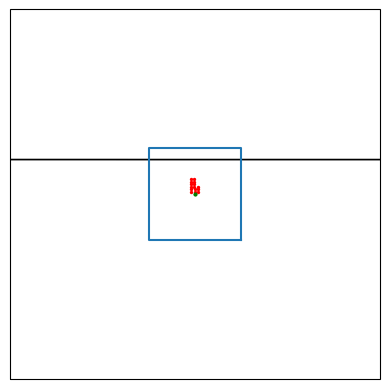

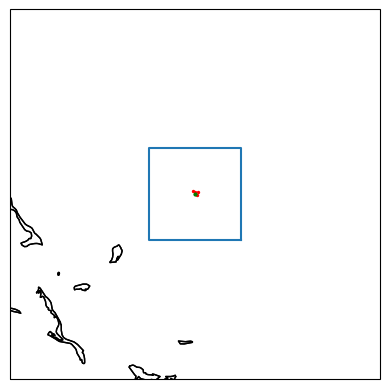

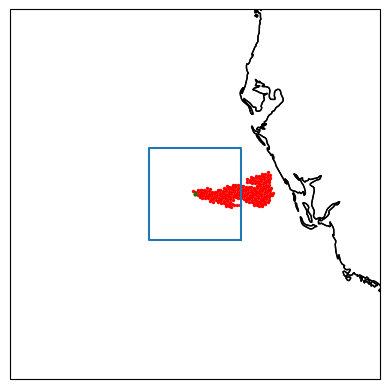

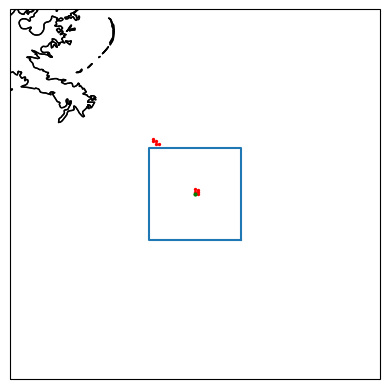

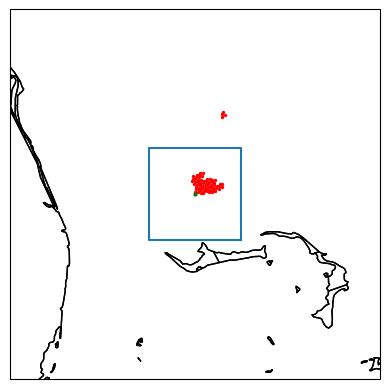

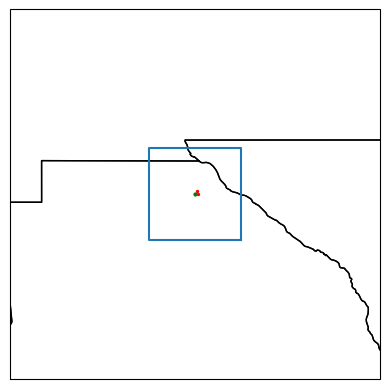

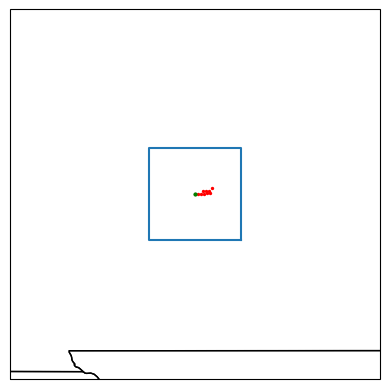

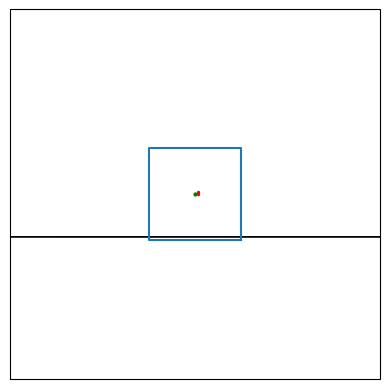

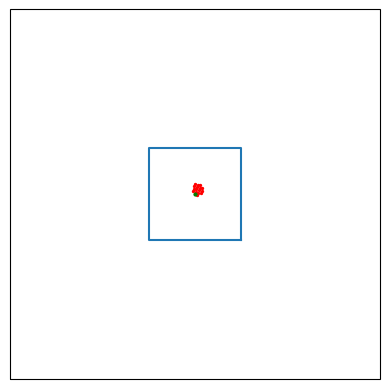

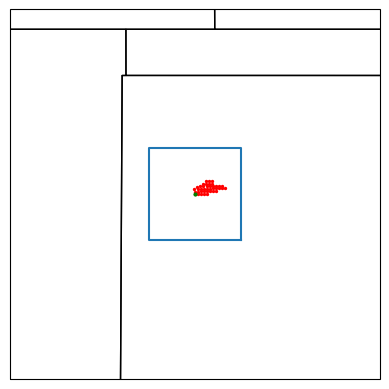

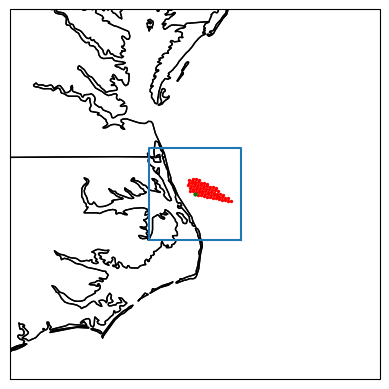

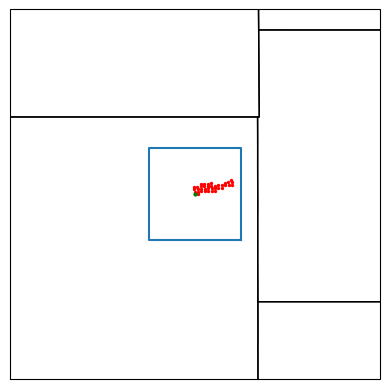

In [84]:
surrogate_slices = get_slices(surrogate_df, hourly_bins[0], 3)
for slice in surrogate_slices:
    slice.plot_slice()

In [85]:
slices = get_slices(events,hourly_bins[1], bin_size)


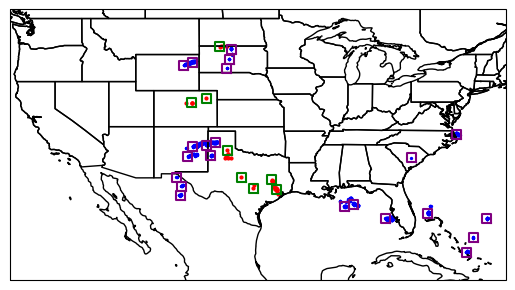

In [104]:
def beeeg_plot(surrogate_report_slices, storm_report_slices):
    figure = plt.figure()
    
    ax = figure.add_subplot(1,1,1,projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.STATES)
    ax.set_extent(
        [-125, -70, 20,50],
        crs=ccrs.PlateCarree()
    )

    for slice in surrogate_report_slices:
        plt.scatter(
            x = slice.df["Lon"],
            y = slice.df["Lat"],
            color='blue',
            s=2,
            alpha=1,
            transform=ccrs.PlateCarree()
        )
        x,y = slice.bounding_box.exterior.xy
        plt.plot(x,y, color='purple')

    for slice in storm_report_slices:
        plt.scatter(
                x = slice.df["Lon"],
                y = slice.df["Lat"],
                color="red",
                s=4,
                alpha=1,
                transform=ccrs.PlateCarree()
            )
        x,y = slice.bounding_box.exterior.xy
        plt.plot(x,y, color='green')
    plt.show()
    return 

    
beeeg_plot(surrogate_slices, slices)


In [59]:
overlaps = [0]*len(slices)
count = 0
for i in range(len(slices)):
    for j in range(len(surrogate_slices)):
        if slices[i].bounding_box.intersects(surrogate_slices[j].bounding_box):
            count += 1
            overlaps[i] = 1
print(overlaps)
print(count)

[0, 0, 0, 1, 0, 1, 0, 0]
4


In [64]:
len(slices), len(surrogate_slices)

(8, 22)

In [67]:
overlaps = [0]*len(surrogate_slices)
count = 0
for i in range(len(surrogate_slices)):
    for j in range(len(slices)):
        if surrogate_slices[i].bounding_box.intersects(slices[j].bounding_box):
            count += 1
            overlaps[i] = 1
            
print(overlaps)
print(count)         
            
print(len(overlaps) - np.array(overlaps).sum())

[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
4
18


In [81]:
lat, lon = events["Lat"], events["Lon"]
X = np.array([[lon[i],lat[i]] for i in range(len(lat))])

In [84]:
from sklearn.cluster import DBSCAN

In [85]:
clustering= DBSCAN(eps=3, min_samples=2).fit(X)

In [86]:
clustering.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       2, 0, 2, 0, 2, 2, 0, 1, 1, 0, 0, 0, 0, 0, 2, 1, 1, 0])

In [87]:
clustering

DBSCAN(eps=3, min_samples=2)

In [48]:
init_time = hourly_bins[0] - pd.Timedelta(hours=6)
hour = 6
dt_list = r.fetch_model_outputs(init_time, [hour, hour +1, hour+2])
aa = []
for dt in dt_list:
    test_d = xr.Dataset(
                data_vars=dict(
                    wind_10m=(["time","ygrid_0", "xgrid_0"], 
                          [((dt.MAXUW_P8_L103_GLC0_max1h.data)**2 + (dt.MAXUW_P8_L103_GLC0_max1h.data)**2)**(1/2)]),
                    # UH_2_5=(["ygrid_0", "xgrid_0"],
                    #        dt.),
                    gust_potential=(["time","ygrid_0", "xgrid_0"], [dt.GUST_P0_L1_GLC0.data]),
                    downdraft_speed=(["time","ygrid_0", "xgrid_0"], [dt.MAXDVV_P8_2L100_GLC0_max1h.data])

                ),
                coords=dict(
                    gridlat_0=(["ygrid_0", "xgrid_0"], dt.coords['gridlat_0'].data),
                    gridlon_0=(["ygrid_0", "xgrid_0"], dt.coords['gridlon_0'].data)
                )
            )
    aa.append(test_d)
n = xr.concat(aa, "time")

In [49]:
n.to_netcdf("./test.nc")

In [50]:
ds = xr.open_dataset("test.nc")

In [53]:
dt_list[0]['MXUPHL_P8_2L103_GLC0_max1h']

<xarray.DataArray 'MXUPHL_P8_2L103_GLC0_max1h' (lv_HTGL11: 2, ygrid_0: 1059,
                                                xgrid_0: 1799)>
[3810282 values with dtype=float32]
Coordinates:
    gridlat_0  (ygrid_0, xgrid_0) float32 21.14 21.15 21.15 ... 47.85 47.84
    gridlon_0  (ygrid_0, xgrid_0) float32 -122.7 -122.7 -122.7 ... -60.95 -60.92
Dimensions without coordinates: lv_HTGL11, ygrid_0, xgrid_0
Attributes: (12/13)
    center:                                         US National Weather Servi...
    production_status:                              Operational products
    long_name:                                      Hourly maximum of updraft...
    units:                                          m2 s-2
    grid_type:                                      Lambert Conformal can be ...
    parameter_discipline_and_category:              Meteorological products, ...
    ...                                             ...
    level_type:                                     Specified height level ab...
    type_of_statistical_processing:                 Maximum
    statistical_process_duration:                   1 hours (ending at foreca...
    forecast_time:                                  [6]
    forecast_time_units:                            hours
    initial_time:                                   06/20/2023 (18:00)

In [ ]:
GUST_P0_L1_GLC0
MAXDVV_P8_2L100_GLC0_max1h
MXUPHL_P8_2L103_GLC0_max1h

In [105]:
data_vars=dict(wind_10m=(["time","ygrid_0", "xgrid_0"], 
                    [((dt.MAXUW_P8_L103_GLC0_max1h.data)**2 + (dt.MAXUW_P8_L103_GLC0_max1h.data)**2)**(1/2)]),
                    # UH_2_5=(["ygrid_0", "xgrid_0"],
                    #        dt.),
                    gust_potential=(["time","ygrid_0", "xgrid_0"], [dt.GUST_P0_L1_GLC0.data]),
                    downdraft_speed=(["time","ygrid_0", "xgrid_0"], [dt.MAXDVV_P8_2L100_GLC0_max1h.data])

                )

In [106]:
data_vars

{'wind_10m': (['time', 'ygrid_0', 'xgrid_0'],
  [array([[ 7.493011 ,  7.493011 ,  7.4046226, ..., 11.82404  , 11.912428 ,
           12.000817 ],
          [ 7.669788 ,  7.669788 ,  7.5813994, ..., 12.000817 , 12.000817 ,
           12.089205 ],
          [ 7.7581763,  7.7581763,  7.669788 , ..., 12.177593 , 12.177593 ,
           12.177593 ],
          ...,
          [ 7.002678 ,  7.002678 ,  7.002678 , ...,  5.234911 ,  5.1465225,
            4.969746 ],
          [ 7.002678 ,  7.002678 ,  7.002678 , ...,  5.411688 ,  5.234911 ,
            5.058134 ],
          [ 7.002678 ,  7.002678 ,  7.002678 , ...,  5.5000763,  5.3232994,
            5.1465225]], dtype=float32)]),
 'gust_potential': (['time', 'ygrid_0', 'xgrid_0'],
  [array([[ 8.7     ,  8.8     ,  8.8     , ...,  9.1     ,  9.1     ,
            9.1     ],
          [ 8.7     ,  9.2     ,  9.2     , ...,  9.900001,  9.900001,
            9.3     ],
          [ 8.6     ,  9.2     ,  9.2     , ..., 10.      , 10.      ,
         